# Mid-term exam Denver region

In [1]:
!pip install shap
!pip install pmdarima

# 1. Business case and value-- what hypotheses are you trying to prove?
1. Is it worth to buy a home in Devnver region? Would there be return of investment?
Based on the data analysis it was found that there are lot of single family homes in the Denver region which is not sold this might be due to the following reasons
    *  Home prices in Denver is high than the median family income so it is not affordable to the general population
    *   There is no return on investment after the purchase of the single family house
    *  Fewer other listing type homes such as condos, multi-family homes are being constructed, but many single family homes are being built at the same time. This would result in higher count of  single family homes.

In this mid-term project I would explain if there is any advantage (profit) of buying a home in Denver region




## 1.1 Data narrative: tell a story to guide an investor or a retiree or just someone interested in buying:
If an investor wants to buy a home in the Denver region this project would let the investor know if it is profitable for purchase. We would also corelate with the rent and profit the investor can achieve by renting the home. Similarly, there are many examples in this notebook which would explain why buying a home is a good idea in Denver region


In [2]:
#  To mount the data from drive to google collab followed the following documentation: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")
import shap

In [3]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from sklearn.preprocessing import MinMaxScaler

In [4]:
downloaded = drive.CreateFile({'id':"10r4_f177szaVb75xuRGvo-Nrn_d26FHJ"})
downloaded.GetContentFile('Dataset_Realestate.csv')

In [5]:
df = pd.read_csv('Dataset_Realestate.csv')
df.head(1)

,rank,property_id,address,latitude,longitude,price,currency,bathrooms,bedrooms,area,land_area,zestimate,rent_zestimate,days_on_zillow,sold_date,is_zillow_owned,image,listing_type,broker_name,input,property_url,listing_url
0,205,70983496,"109 Sunrise Fls, Cibolo, TX 78108",29.599431,-98.254866,296000.0,USD,3.0,3.0,2294.0 sqft,NaN,270100.0,2024.0,0.0,NaN,False,https://photos.zillowstatic.com/fp/41ca4905859...,House for sale,Opendoor Brokerage LLC,https://www.zillow.com/homes/TX_rb/,https://www.zillow.com/homedetails/109-Sunrise...,https://www.zillow.com/homes/TX_rb/6_p/


##### Filtering data based on Denver region

In [6]:
# extract the rows with Denver in the address using regex
import re
df_denver=df[(df.address.str.contains('[.\s]*co\s\d{5}$', flags=re.IGNORECASE|re.DOTALL)==True) & (df.address.str.contains('Denver', flags=re.IGNORECASE)==True)]
df_denver

,rank,property_id,address,latitude,longitude,price,currency,bathrooms,bedrooms,area,land_area,zestimate,rent_zestimate,days_on_zillow,sold_date,is_zillow_owned,image,listing_type,broker_name,input,property_url,listing_url
11,369,58685747,"300 W 11th Ave UNIT 19A, Denver, CO 80204",39.733796,-104.991789,1950000.0,USD,4.0,4.0,3403.0 sqft,NaN,1950000.0,4925.0,7.0,NaN,False,https://photos.zillowstatic.com/fp/c038e48b148...,Condo for sale,"Iconique Real Estate, LLC","https://www.zillow.com/homes/denver,-co_rb/",https://www.zillow.com/homedetails/300-W-11th-...,"https://www.zillow.com/homes/denver,-co_rb/10_p/"
20,253,13310709,"3485 W 33rd Ave, Denver, CO 80211",39.764103,-105.034285,925000.0,USD,3.0,3.0,2042.0 sqft,NaN,961600.0,3694.0,2.0,NaN,False,https://photos.zillowstatic.com/fp/f24c1227ac7...,House for sale,"BSW Real Estate, LLC","https://www.zillow.com/homes/denver,-co_rb/",https://www.zillow.com/homedetails/3485-W-33rd...,"https://www.zillow.com/homes/denver,-co_rb/7_p/"
27,626,251841583,"4048 W 16th Ave, Denver, CO 80204",39.742139,-105.039821,1050000.0,USD,4.0,3.0,2198.0 sqft,NaN,1050000.0,3584.0,21.0,NaN,False,https://photos.zillowstatic.com/fp/5d82b219f2f...,Townhouse for sale,Metrowest Real Estate Solutions,"https://www.zillow.com/homes/denver,-co_rb/",https://www.zillow.com/homedetails/4048-W-16th...,"https://www.zillow.com/homes/denver,-co_rb/16_p/"
28,82,13337383,"740 Meade St, Denver, CO 80204",39.728996,-105.035871,419900.0,USD,1.0,2.0,600.0 sqft,NaN,296100.0,1542.0,1.0,NaN,False,https://photos.zillowstatic.com/fp/c8cb6bf19a8...,House for sale,Keller Williams Realty Downtown LLC,"https://www.zillow.com/homes/denver,-co_rb/",https://www.zillow.com/homedetails/740-Meade-S...,"https://www.zillow.com/homes/denver,-co_rb/3_p/"
40,688,13399472,"605 S Alton Way APT 9C, Denver, CO 80247",39.704425,-104.879653,315000.0,USD,2.0,2.0,1550.0 sqft,NaN,315000.0,2133.0,24.0,NaN,False,https://photos.zillowstatic.com/fp/2be4a9d7d34...,Multi-family home for sale,Coldwell Banker Realty 18,"https://www.zillow.com/homes/denver,-co_rb/",https://www.zillow.com/homedetails/605-S-Alton...,"https://www.zillow.com/homes/denver,-co_rb/18_p/"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5826,68,13407418,"6650 E Arizona Ave APT 158, Denver, CO 80224",39.693902,-104.910403,249900.0,USD,2.0,2.0,944.0 sqft,NaN,257700.0,1597.0,0.0,NaN,False,https://photos.zillowstatic.com/fp/95d65c408d1...,Multi-family home for sale,HomeSmart,"https://www.zillow.com/homes/denver,-co_rb/",https://www.zillow.com/homedetails/6650-E-Ariz...,"https://www.zillow.com/homes/denver,-co_rb/2_p/"
5837,382,13370480,"1315 S Gaylord St, Denver, CO 80210",39.692585,-104.962044,1089000.0,USD,3.0,3.0,2684.0 sqft,NaN,1114900.0,3965.0,7.0,NaN,False,https://photos.zillowstatic.com/fp/e32888c1bc4...,House for sale,#1 METRO PROPERTIES,"https://www.zillow.com/homes/denver,-co_rb/",https://www.zillow.com/homedetails/1315-S-Gayl...,"https://www.zillow.com/homes/denver,-co_rb/10_p/"
5846,491,13348114,"366 Monroe St, Denver, CO 80206",39.722229,-104.944619,3450000.0,USD,5.0,4.0,6791.0 sqft,NaN,3450000.0,11352.0,11.0,NaN,False,https://photos.zillowstatic.com/fp/53f8b60c974...,House for sale,Keller Williams Realty Downtown LLC,"https://www.zillow.com/homes/denver,-co_rb/",https://www.zillow.com/homedetails/366-Monroe-...,"https://www.zillow.com/homes/denver,-co_rb/13_p/"
5866,658,13303825,"2633 E 30th Ave, Denver, CO 80205",39.759663,-104.955255,599000.0,USD,1.0,3.0,1357.0 sqft,NaN,604500.0,2296.0,22.0,NaN,False,https://photos.zillowstatic.com/fp/09b27420bd1...,House for sale,Redfin Corporation,"https://www.zillow.com/homes/denver,-co_rb/",https://www.zillow.com/homedetails/2633-E-30th...,"https://www.zillow.com/homes/denver,-co_rb/17_p/"


# 2. visualizations, of data prep using first data enrichment


In [7]:
df_denver.shape

(719, 22)

In [8]:
df_denver.describe()

,rank,property_id,latitude,longitude,price,bathrooms,bedrooms,zestimate,rent_zestimate,days_on_zillow,sold_date
count,719.000000,7.190000e+02,719.000000,719.000000,7.190000e+02,707.000000,709.000000,6.610000e+02,683.000000,719.000000,0.0
mean,399.560501,2.360555e+08,39.722218,-104.958714,7.501569e+05,2.437058,2.856135,7.479550e+05,2946.874085,10.926287,NaN
std,237.800527,6.024386e+08,0.042567,0.065379,6.428857e+05,1.278471,1.372308,6.086956e+05,1803.703336,10.718290,NaN
min,1.000000,1.304499e+07,39.614956,-105.106997,1.349000e+05,1.000000,0.000000,1.344000e+05,980.000000,0.000000,NaN
25%,184.500000,1.333392e+07,39.691001,-104.998773,4.000000e+05,2.000000,2.000000,4.132000e+05,2028.000000,1.000000,NaN
50%,412.000000,1.339942e+07,39.728773,-104.966710,5.840000e+05,2.000000,3.000000,5.864000e+05,2506.000000,8.000000,NaN
75%,608.500000,6.744916e+07,39.753540,-104.918669,8.465000e+05,3.000000,4.000000,8.439000e+05,3200.000000,19.000000,NaN
max,800.000000,2.144664e+09,39.847608,-104.691118,6.500000e+06,11.000000,9.000000,6.410900e+06,24770.000000,36.000000,NaN


In [9]:
df_denver.isnull().sum()

rank                 0
property_id          0
address              0
latitude             0
longitude            0
price                0
currency             0
bathrooms           12
bedrooms            10
area                 8
land_area          711
zestimate           58
rent_zestimate      36
days_on_zillow       0
sold_date          719
is_zillow_owned      0
image                0
listing_type         0
broker_name          8
input                0
property_url         0
listing_url          0
dtype: int64

#### Imputation of data

In [10]:
# categories such as "land_area", "sold_date" has highest number on nan values droping such columns
df_denver= df_denver.drop(columns=['land_area', 'sold_date'])

In [11]:
df_denver=df_denver.replace(np.nan, 0)

In [12]:
df_denver.isnull().sum()

rank               0
property_id        0
address            0
latitude           0
longitude          0
price              0
currency           0
bathrooms          0
bedrooms           0
area               0
zestimate          0
rent_zestimate     0
days_on_zillow     0
is_zillow_owned    0
image              0
listing_type       0
broker_name        0
input              0
property_url       0
listing_url        0
dtype: int64

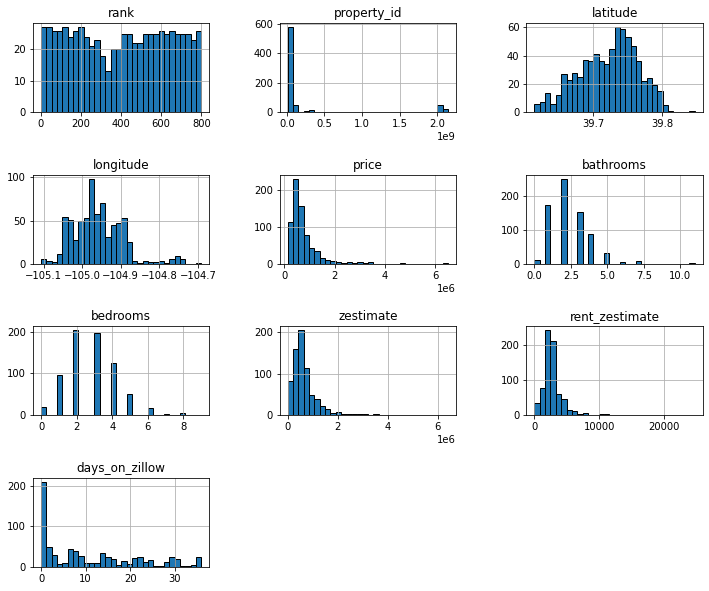

In [13]:
# Bedrooms and bathrooms are not uniformly binned
dis_selected_cols=['rank', 'property_id', 'latitude', 'longitude', 'price', 'bathrooms' , 'bedrooms', 'area', 'zestimate', 'rent_zestimate', 'days_on_zillow']
df_denver_hist=df_denver.copy()
df_denver_hist=df_denver_hist[dis_selected_cols]
df_denver_hist.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [14]:
# Scatter plot comparison of price, rent_zestimate, zestimate per listing type
import plotly.express as px
fig = px.scatter_matrix(df_denver, dimensions=["area","price"], color="listing_type")
fig.show()

From the above analysis we can conclude that as the area of the property increases the price of the property also increases
There are many homes for sale with price ranging between 800k to 2.5 million
As the area of the home increases the price of the home also increases

Text(0, 0.5, 'Counts')

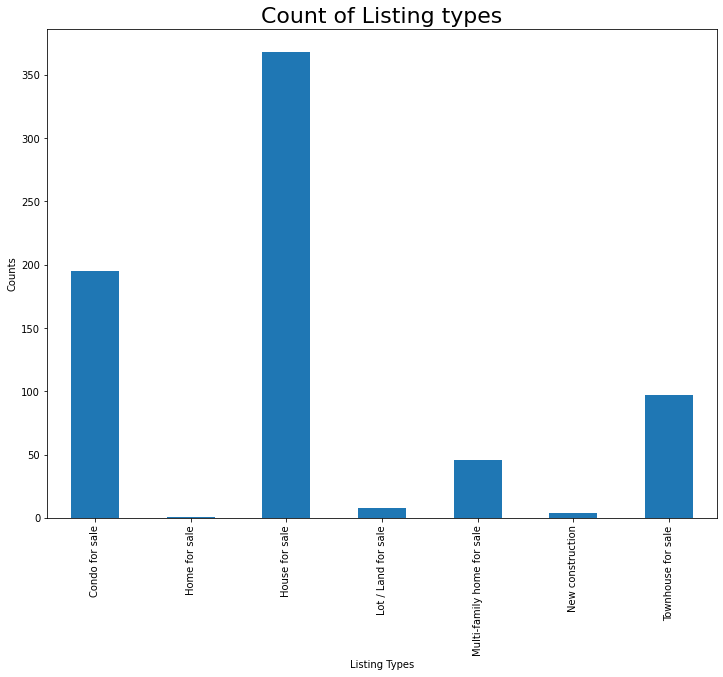

In [15]:
fig, ax = plt.subplots()
df_denver['listing_type'].value_counts().sort_index().plot(ax=ax, kind='bar', figsize=(12,9))
plt.title("Count of Listing types", fontsize=22)
plt.xlabel("Listing Types")
plt.ylabel("Counts")

In the Denver region there are many homes for sale.
This might be due to more supply and less demand when compared to the other listing type

In [16]:
listing_type = df_denver.groupby(["listing_type"])
sum_listing_type = listing_type["price"].mean()
rent_listing_type=listing_type["rent_zestimate"].mean()
print (sum_listing_type, rent_listing_type)

listing_type
Condo for sale                553045.666667
Home for sale                 439000.000000
House for sale                888784.331522
Lot / Land for sale           659875.000000
Multi-family home for sale    742574.782609
New construction              532100.000000
Townhouse for sale            643726.000000
Name: price, dtype: float64 listing_type
Condo for sale                2289.328205
Home for sale                 2662.000000
House for sale                3197.364130
Lot / Land for sale           1614.750000
Multi-family home for sale    2407.521739
New construction               642.500000
Townhouse for sale            2688.350515
Name: rent_zestimate, dtype: float64


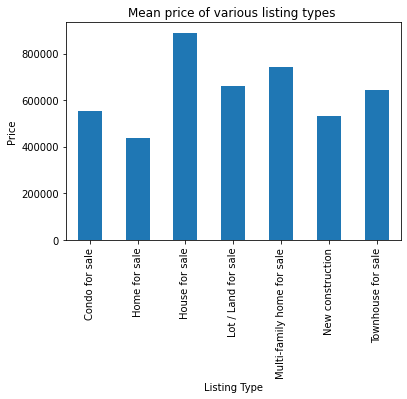

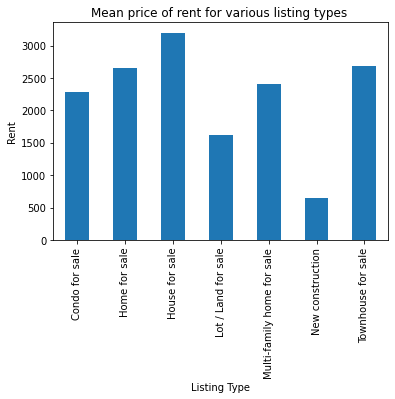

In [17]:
sum_listing_type.plot(kind="bar")
plt.title("Mean price of various listing types ")
plt.ylabel("Price")
plt.xlabel("Listing Type")
plt.show()
rent_listing_type.plot(kind="bar")
plt.title("Mean price of rent for various listing types ")
plt.ylabel("Rent")
plt.xlabel("Listing Type")
plt.show()

The increase in homes for sale might be due to the higher purchace cost and higher price for rent.
The annaula income of people in Denver might be low to pay for the price for homes

<Figure size 864x864 with 0 Axes>

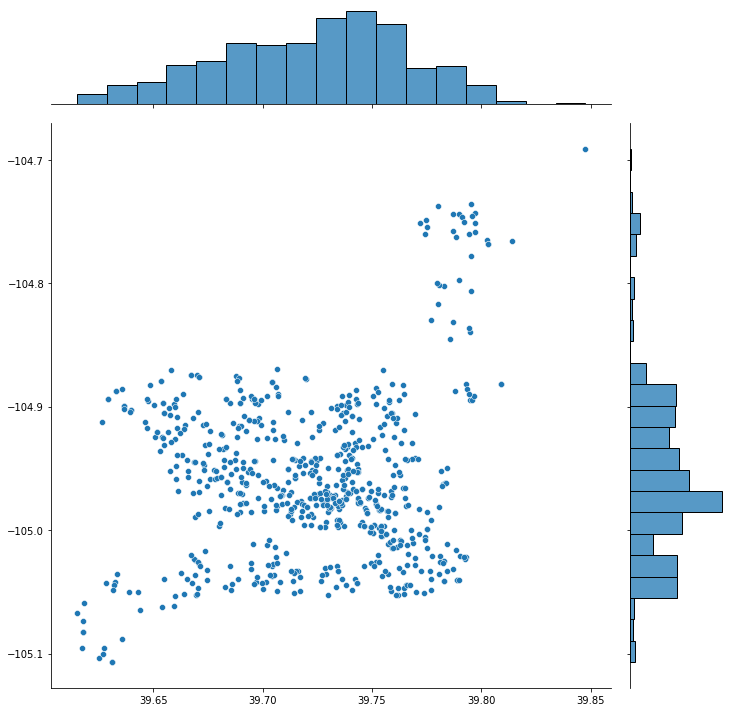

In [18]:
plt.figure(figsize=(12,12))
sns.jointplot(x=df_denver.latitude.values, y=df_denver.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

Most of the homes are concentrated in one region

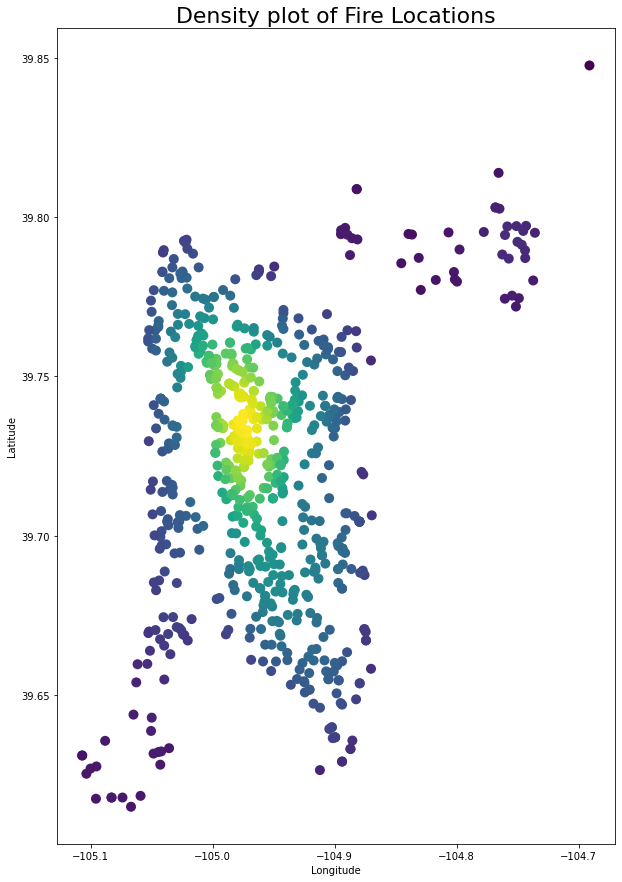

In [19]:
df_denver.drop(df_denver[(df_denver.latitude < -90) | (df_denver.latitude > 90)].index, inplace=True)
df_denver.drop(df_denver[(df_denver.longitude < -180) | (df_denver.longitude >= 0)].index, inplace=True)
from scipy.stats import gaussian_kde
x = df_denver['longitude']
y = df_denver['latitude']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize=(10, 15))
ax.scatter(x, y, c=z, s=100, edgecolor='')

plt.title("Density plot of Fire Locations", fontsize=22)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

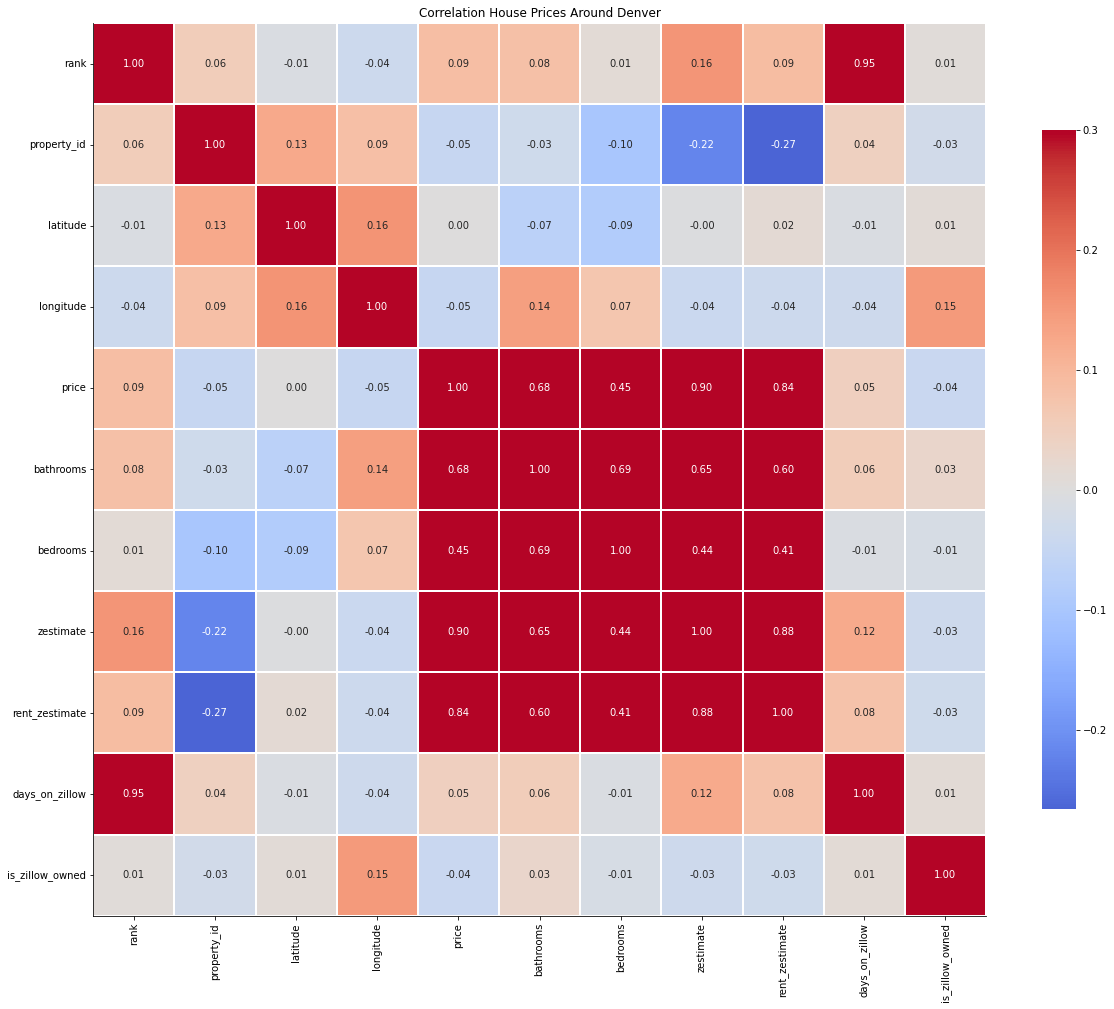

In [20]:
corr = df_denver.corr()
g = sns.heatmap(corr,  vmax=.3, center=0,square=True, linewidths=1, cbar_kws={"shrink": 0.5}, annot=True, fmt='.2f', cmap='coolwarm')
sns.despine()
g.figure.set_size_inches(20,25)
plt.title('Correlation House Prices Around Denver')
plt.show()


The co-realted attributes are: price, bathrooms, bedrooms, zestimate, rent_zestimate

##  2.1 Feature importance and Gini Score
To select the important features for our dataset I am performing the following analysis
### 2.1.1 Gini importance using Random forest


In [21]:
df_denver_copy = df_denver.copy()
df_denver_copy1= df_denver.copy()

In [22]:
df_denver_copy.head(2)

,rank,property_id,address,latitude,longitude,price,currency,bathrooms,bedrooms,area,zestimate,rent_zestimate,days_on_zillow,is_zillow_owned,image,listing_type,broker_name,input,property_url,listing_url
11,369,58685747,"300 W 11th Ave UNIT 19A, Denver, CO 80204",39.733796,-104.991789,1950000.0,USD,4.0,4.0,3403.0 sqft,1950000.0,4925.0,7.0,False,https://photos.zillowstatic.com/fp/c038e48b148...,Condo for sale,"Iconique Real Estate, LLC","https://www.zillow.com/homes/denver,-co_rb/",https://www.zillow.com/homedetails/300-W-11th-...,"https://www.zillow.com/homes/denver,-co_rb/10_p/"
20,253,13310709,"3485 W 33rd Ave, Denver, CO 80211",39.764103,-105.034285,925000.0,USD,3.0,3.0,2042.0 sqft,961600.0,3694.0,2.0,False,https://photos.zillowstatic.com/fp/f24c1227ac7...,House for sale,"BSW Real Estate, LLC","https://www.zillow.com/homes/denver,-co_rb/",https://www.zillow.com/homedetails/3485-W-33rd...,"https://www.zillow.com/homes/denver,-co_rb/7_p/"


In [23]:
# converting string attributes to the codes
df_denver_copy['address'] = df_denver_copy['address'].astype('category').cat.codes
df_denver_copy['area'] = df_denver_copy['area'].astype('category').cat.codes
df_denver_copy['listing_type'] = df_denver_copy['listing_type'].astype('category').cat.codes
df_denver_copy['broker_name'] = df_denver_copy['broker_name'].astype('category').cat.codes
df_denver_copy['input'] = df_denver_copy['input'].astype('category').cat.codes
df_denver_copy['image'] = df_denver_copy['image'].astype('category').cat.codes
df_denver_copy['property_url'] = df_denver_copy['property_url'].astype('category').cat.codes
df_denver_copy['listing_url'] = df_denver_copy['listing_url'].astype('category').cat.codes

In [24]:
df_denver_copy.dtypes 

rank                 int64
property_id          int64
address              int16
latitude           float64
longitude          float64
price              float64
currency            object
bathrooms          float64
bedrooms           float64
area                 int16
zestimate          float64
rent_zestimate     float64
days_on_zillow     float64
is_zillow_owned       bool
image                int16
listing_type          int8
broker_name          int16
input                 int8
property_url         int16
listing_url           int8
dtype: object

In [25]:
# selecting the important correlated attributes
column_name=['price','bathrooms','bedrooms','area','zestimate',
             'rent_zestimate','days_on_zillow']
selected_df= df_denver_copy[column_name]
X=pd.DataFrame(selected_df, columns=column_name)
y=pd.DataFrame(selected_df, columns=column_name)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

In [26]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [27]:
rf.feature_importances_

array([0.37267965, 0.00219178, 0.00262772, 0.00462268, 0.60816279,
       0.00777712, 0.00193825])

Text(0.5, 0, 'Random Forest Feature Importance')

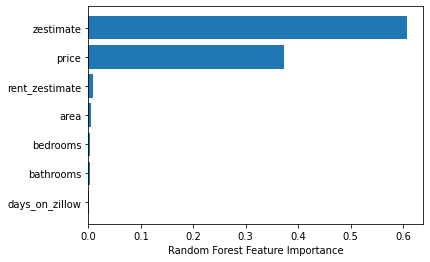

In [28]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(selected_df.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Through random forest the important attributes are:
1) Zestimate
2) Price
3) Rent estimate
4) Area

### 2.1.2 Permutation-based Importance

In [29]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(rf, X_test, y_test)

Text(0.5, 0, 'Permutation Importance')

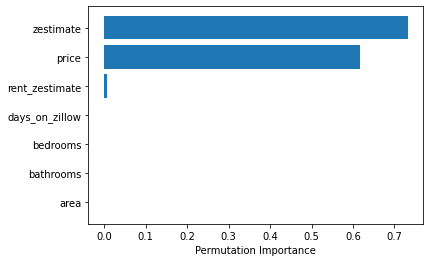

In [30]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(selected_df.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

Throiugh permutation based attribute analysis the important attributes are zestimate, price

### 2.1.3 SHAP Values

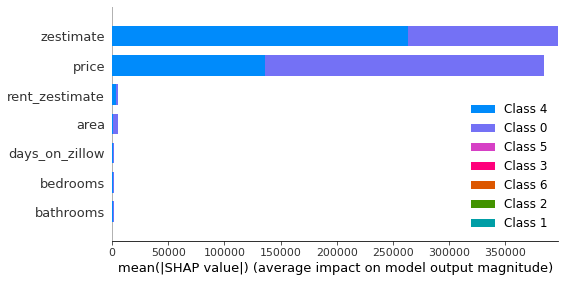

In [31]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")


Through all the 3 analysis I am considering using zestimate, price, rent_estimate as critical features

## 2.1.4 Feature Importance PCA

In [32]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
pca.fit(selected_df)


PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [33]:
print(pca.components_)

[[7.22300971e-01 1.01944820e-06 7.32492670e-07 2.42735767e-05
  6.91576268e-01 1.89028464e-03 1.04116023e-06]]


In [34]:
print(pca.explained_variance_)

[7.56542707e+11]


In [35]:
print(pca.explained_variance_ratio_)

[0.95110932]


Text(0.5, 1.0, 'The number of components needed to explain variance')

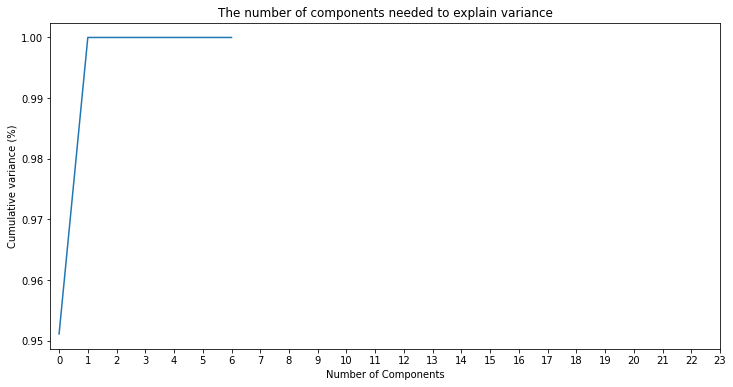

In [36]:

plt.rcParams["figure.figsize"] = (12,6)
pca = PCA().fit(selected_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 24, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

Through PCA we can conculde that we can reduce the dataset to one co-ordinate

# 3. Data Preparation and 4. Amalgamation

For the Denver region I am appending the following datasets from the Zillow https://www.zillow.com/research/data/ website and filter the datset based on the region
## 3.1 Feature Transformation
Containing the data from zillow for 1, 2, 3,4, 5 bedrooms houses and transforming it based on time


In [37]:
def load_zillow_data_house(state=None,county=None,region=None,city=None):

    # Make a dictionary of file paths
    dictionary_with_file_paths = {
    '/content/drive/MyDrive/Machine Learning-MidTerm/Dataset/dataset/DaysOnZillow_City.csv' : 'DaysOnZillow_City',
    '/content/drive/MyDrive/Machine Learning-MidTerm/Dataset/dataset/Sale_Prices_City.csv' : 'Sale_Prices_City',
    '/content/drive/MyDrive/Machine Learning-MidTerm/Dataset/dataset/City_MedianRentalPrice_Studio.csv' : 'City_MedianRentalPrice_Studio',
    '/content/drive/MyDrive/Machine Learning-MidTerm/Dataset/dataset/City_MedianRentalPrice_1Bedroom.csv' : 'City_MedianRentalPrice_1Bedroom',
    '/content/drive/MyDrive/Machine Learning-MidTerm/Dataset/dataset/City_MedianRentalPrice_2Bedroom.csv' : 'City_MedianRentalPrice_2Bedroom',
    '/content/drive/MyDrive/Machine Learning-MidTerm/Dataset/dataset/City_MedianRentalPrice_3Bedroom.csv' : 'City_MedianRentalPrice_3Bedroom',
    '/content/drive/MyDrive/Machine Learning-MidTerm/Dataset/dataset/City_MedianRentalPrice_4Bedroom.csv' : 'City_MedianRentalPrice_4Bedroom',
    '/content/drive/MyDrive/Machine Learning-MidTerm/Dataset/dataset/City_MedianRentalPrice_5BedroomOrMore.csv' : 'City_MedianRentalPrice_5BedroomOrMore',
    '/content/drive/MyDrive/Machine Learning-MidTerm/Dataset/dataset/City_Zhvi_1bedroom.csv' : 'City_Zhvi_1bedroom',
    '/content/drive/MyDrive/Machine Learning-MidTerm/Dataset/dataset/City_Zhvi_2bedroom.csv' : 'City_Zhvi_2bedroom',
    '/content/drive/MyDrive/Machine Learning-MidTerm/Dataset/dataset/City_Zhvi_3bedroom.csv' : 'City_Zhvi_3bedroom',
    '/content/drive/MyDrive/Machine Learning-MidTerm/Dataset/dataset/City_Zhvi_4bedroom.csv' : 'City_Zhvi_4bedroom',
    '/content/drive/MyDrive/Machine Learning-MidTerm/Dataset/dataset/City_Zhvi_5BedroomOrMore.csv' : 'City_Zhvi_5BedroomOrMore',
    '/content/drive/MyDrive/Machine Learning-MidTerm/Dataset/dataset/City_Zhvi_AllHomes.csv' : 'City_Zhvi_AllHomes',
    '/content/drive/MyDrive/Machine Learning-MidTerm/Dataset/dataset/City_Zhvi_SingleFamilyResidence.csv' : 'City_Zhvi_SingleFamilyResidence',
    '/content/drive/MyDrive/Machine Learning-MidTerm/Dataset/dataset/City_Zhvi_Condominum.csv' : 'City_Zhvi_Condominum'
    }

    # Load the files from the file paths into a dictionary of dataframes
    dictionary_with_dataframes = {}
    for file_path, file_name in dictionary_with_file_paths.items():
        name_of_dataframe = str(file_name)
        dictionary_with_dataframes[name_of_dataframe] = pd.read_csv(file_path)
        dictionary_with_dataframes[name_of_dataframe].rename(columns={'Unnamed: 0':'which_measurement'}, inplace=True)
        dictionary_with_dataframes[name_of_dataframe]['which_measurement'] = name_of_dataframe

    # Combine the dataframes into one large dataframe that has a new column that labels each subsection
    filtered_dataframe = pd.concat(dictionary_with_dataframes.values(), ignore_index=True, sort=True)

    # Filter the data according to your needs
    states_to_keep = [state]
    counties_to_keep = [county]
    regions_to_keep = [region]
    cities_to_keep = [city]
    if state == None:
        pass
    else:
        filtered_dataframe = filtered_dataframe[filtered_dataframe.StateName.isin(states_to_keep)] 
    if county == None:
        pass
    else:    
        filtered_dataframe = filtered_dataframe[filtered_dataframe.CountyName.isin(counties_to_keep)]
    if region == None:
        pass
    else:     
        filtered_dataframe = filtered_dataframe[filtered_dataframe.RegionName.isin(regions_to_keep)]
    if city == None:
        pass
    else:     
        filtered_dataframe = filtered_dataframe[filtered_dataframe.Metro.isin(cities_to_keep)]

    # Reshape and transform data based on time
    for row in filtered_dataframe:
        final_df = filtered_dataframe[['2008-03-31','2008-04-30','2008-05-31',
       '2008-06-30', '2008-07-31', '2008-08-31', '2008-09-30',
       '2008-10-31', '2008-11-30', '2008-12-31', '2009-01-31',
       '2009-02-28', '2009-03-31', '2009-04-30', '2009-05-31',
       '2009-06-30', '2009-07-31', '2009-08-31', '2009-09-30',
       '2009-10-31', '2009-11-30', '2009-12-31', '2010-01-31',
       '2010-02-28', '2010-03-31', '2010-04-30', '2010-05-31',
       '2010-06-30', '2010-07-31', '2010-08-31', '2010-09-30',
       '2010-10-31', '2010-11-30', '2010-12-31', '2011-01-31',
       '2011-02-28', '2011-03-31', '2011-04-30', '2011-05-31',
       '2011-06-30', '2011-07-31', '2011-08-31', '2011-09-30',
       '2011-10-31', '2011-11-30', '2011-12-31', '2012-01-31',
       '2012-02-29', '2012-03-31', '2012-04-30', '2012-05-31',
       '2012-06-30', '2012-07-31', '2012-08-31', '2012-09-30',
       '2012-10-31', '2012-11-30', '2012-12-31', '2013-01-31',
       '2013-02-28', '2013-03-31', '2013-04-30', '2013-05-31',
       '2013-06-30', '2013-07-31', '2013-08-31', '2013-09-30',
       '2013-10-31', '2013-11-30', '2013-12-31', '2014-01-31',
       '2014-02-28', '2014-03-31', '2014-04-30', '2014-05-31',
       '2014-06-30', '2014-07-31', '2014-08-31', '2014-09-30',
       '2014-10-31', '2014-11-30', '2014-12-31', '2015-01-31',
       '2015-02-28', '2015-03-31', '2015-04-30', '2015-05-31',
       '2015-06-30', '2015-07-31', '2015-08-31', '2015-09-30',
       '2015-10-31', '2015-11-30', '2015-12-31', '2016-01-31',
       '2016-02-29', '2016-03-31', '2016-04-30', '2016-05-31',
       '2016-06-30', '2016-07-31', '2016-08-31', '2016-09-30',
       '2016-10-31', '2016-11-30', '2016-12-31', '2017-01-31',
       '2017-02-28', '2017-03-31', '2017-04-30', '2017-05-31',
       '2017-06-30', '2017-07-31', '2017-08-31', '2017-09-30',
       '2017-10-31', '2017-11-30', '2017-12-31', '2018-01-31',
       '2018-02-28', '2018-03-31', '2018-04-30', '2018-05-31',
       '2018-06-30', '2018-07-31', '2018-08-31', '2018-09-30',
       '2018-10-31', '2018-11-30', '2018-12-31', '2019-01-31',
       '2019-02-28', '2019-03-31', '2019-04-30', '2019-05-31',
       '2019-06-30', '2019-07-31', '2019-08-31', '2019-09-30',
       '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
       '2020-02-29', '2020-03-31','which_measurement']]
        column_title = final_df['which_measurement'].values
        final_df = final_df.T[:-1]#.fillna(0)
        final_df.columns = [column_title]
    final_df.columns = [  'City_Zhvi_1bedroom','City_Zhvi_2bedroom','City_Zhvi_3bedroom',
                          'City_Zhvi_4bedroom','City_Zhvi_5BedroomOrMore','City_Zhvi_AllHomes',
                          'City_Zhvi_SingleFamilyResidence','City_Zhvi_Condominum']
    final_df['Date'] = final_df.index
    return final_df

In [38]:
data_amal = load_zillow_data_house(state='CO',county='Denver County',
                              region='Denver', city='Denver-Aurora-Lakewood')

In [39]:
data_amal

,City_Zhvi_1bedroom,City_Zhvi_2bedroom,City_Zhvi_3bedroom,City_Zhvi_4bedroom,City_Zhvi_5BedroomOrMore,City_Zhvi_AllHomes,City_Zhvi_SingleFamilyResidence,City_Zhvi_Condominum,Date
2008-03-31,157723,221121,267299,363536,512720,256545,272028,191251,2008-03-31
2008-04-30,156163,219055,264926,360367,506142,254144,269514,189491,2008-04-30
2008-05-31,154250,216367,261843,356653,499617,251139,266388,187352,2008-05-31
2008-06-30,153096,214450,259820,354233,494577,249083,264308,185932,2008-06-30
2008-07-31,151972,212546,257464,351004,488983,246771,261950,184337,2008-07-31
...,...,...,...,...,...,...,...,...,...
2019-11-30,287684,396203,482684,612671,813614,457096,490027,312444,2019-11-30
2019-12-31,288115,397123,484356,614659,816386,458434,491611,312946,2019-12-31
2020-01-31,289186,398527,486536,617124,819281,460255,493706,313832,2020-01-31
2020-02-29,290675,400400,489363,620448,823576,462640,496400,315097,2020-02-29


Text(0, 0.5, 'Price')

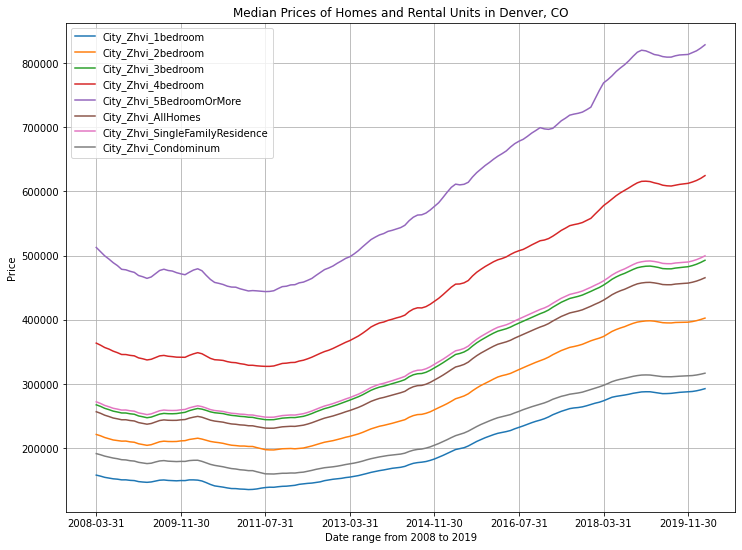

In [40]:
import matplotlib.pyplot as plt
data_amal.plot(title='Median Prices of Homes and Rental Units in Denver, CO',figsize=(12,9), grid=True)
plt.xlabel("Date range from 2008 to 2019")
plt.ylabel("Price")

This transformation helped me to predict the raise in price in the Denver region.
From the above analysis the price of the home in the Denver region has increased by 75% from 2008 to 2019. So purchasing the home was profitable





In [41]:
selected_df

,price,bathrooms,bedrooms,area,zestimate,rent_zestimate,days_on_zillow
11,1950000.0,4.0,4.0,404,1950000.0,4925.0,7.0
20,925000.0,3.0,3.0,235,961600.0,3694.0,2.0
27,1050000.0,4.0,3.0,270,1050000.0,3584.0,21.0
28,419900.0,1.0,2.0,500,296100.0,1542.0,1.0
40,315000.0,2.0,2.0,130,315000.0,2133.0,24.0
...,...,...,...,...,...,...,...
5826,249900.0,2.0,2.0,593,257700.0,1597.0,0.0
5837,1089000.0,3.0,3.0,331,1114900.0,3965.0,7.0
5846,3450000.0,5.0,4.0,522,3450000.0,11352.0,11.0
5866,599000.0,1.0,3.0,90,604500.0,2296.0,22.0


# 5 Implement ml algorithms to build models and refine your data narrative
## 5.1 Golden cluster
To calculate the golden cluster. I wanted to understand the relation between the price, rent

In [42]:
selected_columns=["price", "zestimate"]
df_gc1= df_denver_copy[selected_columns]
df_gc1

,price,zestimate
11,1950000.0,1950000.0
20,925000.0,961600.0
27,1050000.0,1050000.0
28,419900.0,296100.0
40,315000.0,315000.0
...,...,...
5826,249900.0,257700.0
5837,1089000.0,1114900.0
5846,3450000.0,3450000.0
5866,599000.0,604500.0


In [43]:
def plot_cluster(n, max_loop=50):
  # transforming the data using the standard scaler
    X = df_gc1.values
    sc = StandardScaler()
    stdsca = sc.fit_transform(X)
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k,  random_state=10, n_init=10, n_jobs=-1)
        kmeans.fit(stdsca)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(stdsca, kmeans.labels_, random_state=10)
    _ = plt.figure(figsize=(10,6))
    ax1 = plt.subplot(211)
    _ = plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("SSE Within Cluster")
    _ = plt.title("Within Cluster SSE K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    ax2 = plt.subplot(212)
    _ = plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    _ = plt.xlabel("Number of Clusters")
    _ = plt.ylabel("Silhouette Score")
    _ = plt.title("Silhouette Score K-Means Clustering")
    _ = plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)

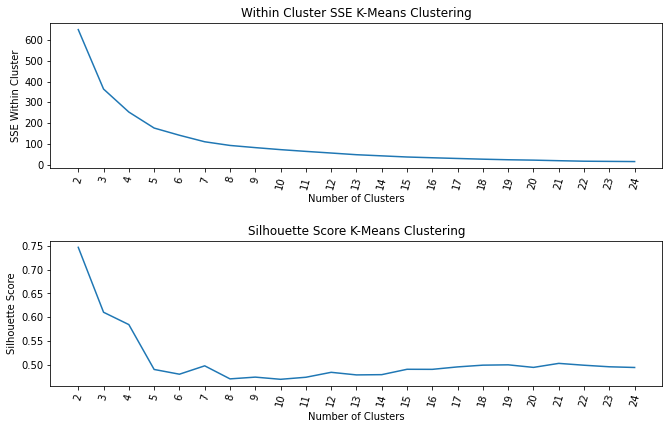

In [44]:
plot_cluster(df_gc1, max_loop=25)

For 3 clusters the Silhouette score is high with stable and gradually decreasing SSE.

In [45]:
# Applying Silhouette Score
def apply_cluster(n, clusters=3):
    X = df_gc1.values
    sc = StandardScaler()
    scaStd = sc.fit_transform(X)

    kmeans = KMeans(n_clusters = clusters, init = 'k-means++', random_state = 42) 
    y_kmeans = kmeans.fit_predict(scaStd)
    score = metrics.silhouette_score(scaStd, kmeans.labels_, random_state=10)
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("-----------------------------------")
    print("silhouette score1: " + str(score.round(2)))
    print("sse withing cluster1: " + str(sse_within_cluster.round()))
    return n

In [46]:
first_trial = apply_cluster(df_gc1, clusters=8)

clustering performance
-----------------------------------
silhouette score1: 0.48
sse withing cluster1: 93.0


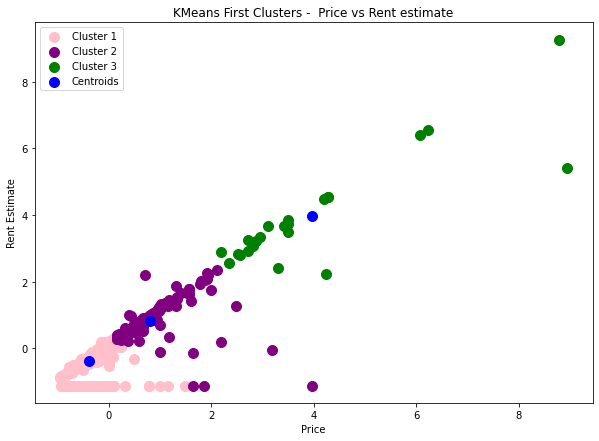

In [47]:
from sklearn.preprocessing import StandardScaler
X = df_gc1.values
# Standard Scaler
sc = StandardScaler()
S_c = sc.fit_transform(X)

kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(S_c)

plt.figure(figsize=(10,7))
plt.scatter(S_c[y_kmeans == 0, 0], S_c[y_kmeans == 0, 1], s = 100, c = 'pink', label = 'Cluster 1')
plt.scatter(S_c[y_kmeans == 1, 0], S_c[y_kmeans == 1, 1], s = 100, c = 'purple', label = 'Cluster 2')
plt.scatter(S_c[y_kmeans == 2, 0], S_c[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'blue', label = 'Centroids')
plt.title('KMeans First Clusters -  Price vs Rent estimate')
plt.xlabel('Price')
plt.ylabel('Rent Estimate')
plt.legend()
plt.show()

From the above cluster we can find thaty the price and rent is directly proportal to each other

## 5.1.2 Fractal clustering

In [48]:
# choosing attributes for th factral clustering based on the SHAP score
Cluster = df_denver_copy1[['price','rent_zestimate', 'address', 'listing_type']]

In [49]:
df_cluster = df_denver_copy1._get_numeric_data().dropna(axis=1)
Cluster['cluster1'] = pd.Series(y_kmeans, index=df_denver_copy1.index)

In [50]:
cluster_performance = (Cluster.groupby('cluster1')
    .agg({"price":'mean',"rent_zestimate":"mean", "address":"count", "listing_type":"count"})
    .sort_values('listing_type')
    .reset_index())

cluster_performance

,cluster1,price,rent_zestimate,address,listing_type
0,2,3.293478e+06,9423.347826,23,23
1,1,1.265459e+06,4047.850340,147,147
2,0,5.056290e+05,2187.511840,549,549


In [51]:
cluster1 = Cluster.query("cluster1 == 0").reset_index(drop=True)
cluster1 = cluster1.drop('cluster1',axis = 1)
cluster1

,price,rent_zestimate,address,listing_type
0,419900.0,1542.0,"740 Meade St, Denver, CO 80204",House for sale
1,315000.0,2133.0,"605 S Alton Way APT 9C, Denver, CO 80247",Multi-family home for sale
2,469000.0,1594.0,"2708 E Mexico Ave, Denver, CO 80210",Lot / Land for sale
3,750000.0,2499.0,"3740 E Iowa Ave, Denver, CO 80210",House for sale
4,400000.0,2395.0,"1888 S Jackson St APT 1001, Denver, CO 80210",Condo for sale
...,...,...,...,...
544,699500.0,2920.0,"779 N Lafayette St, Denver, CO 80218",Townhouse for sale
545,599999.0,1679.0,"3711 Pecos St, Denver, CO 80211",House for sale
546,249900.0,1597.0,"6650 E Arizona Ave APT 158, Denver, CO 80224",Multi-family home for sale
547,599000.0,2296.0,"2633 E 30th Ave, Denver, CO 80205",House for sale


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f06676c4290>,
      dtype=object)

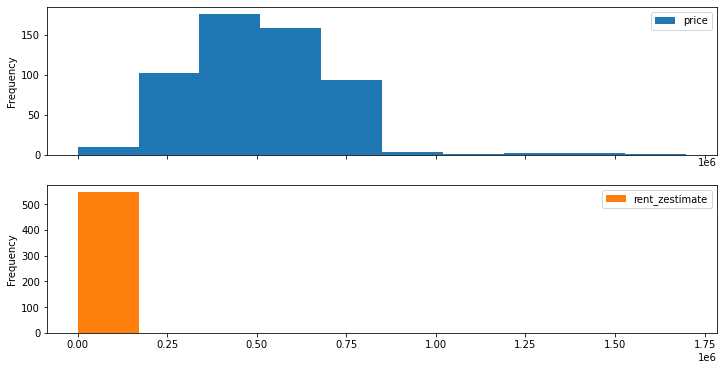

In [52]:
# we can find that price has more bins when compared to rent
cluster1[["price", "rent_zestimate"]].plot(bins=10, kind="hist", subplots=True)

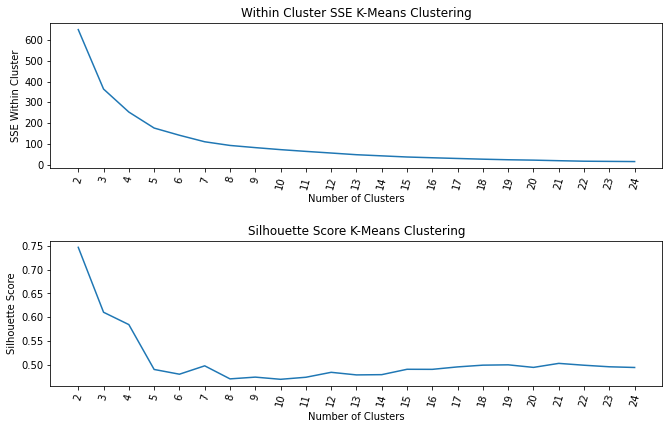

In [53]:
plot_cluster(cluster1[["price", "rent_zestimate"]], max_loop=25)

for cluster 2 the silhouette score is the highest

In [54]:
# Applying Silhouette Score
def apply_cluster(n, clusters=2):


    X = df_denver_copy1.iloc[:, [5, 10]].values
    sc = StandardScaler()
    sca = sc.fit_transform(X)

    kmeans = KMeans(n_clusters = clusters, init = 'k-means++', random_state = 42) 
    y_kmeans = kmeans.fit_predict(sca)
    score = metrics.silhouette_score(sca, kmeans.labels_, random_state=10)
    sse_within_cluster = kmeans.inertia_
    
    print("clustering performance")
    print("-----------------------------------")
    print("silhouette score2: " + str(score.round(2)))
    print("sse withing cluster2: " + str(sse_within_cluster.round()))
    
    return n

In [55]:
second_trial = apply_cluster(cluster1[["price", "rent_zestimate"]], clusters=2)

clustering performance
-----------------------------------
silhouette score2: 0.75
sse withing cluster2: 650.0


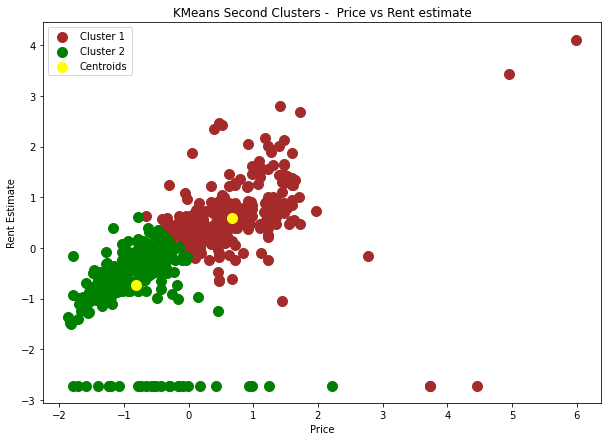

In [56]:
# Performing Second Kmeans using Clusters = 2
# Standard Scaler
sc = StandardScaler()
S_c = sc.fit_transform(cluster1[["price", "rent_zestimate"]])

kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans_5 = kmeans.fit_predict(S_c)

plt.figure(figsize=(10,7))
plt.scatter(S_c[y_kmeans_5 == 0, 0], S_c[y_kmeans_5 == 0, 1], s = 100, c = 'brown', label = 'Cluster 1')
plt.scatter(S_c[y_kmeans_5 == 1, 0], S_c[y_kmeans_5 == 1, 1], s = 100, c = 'green', label = 'Cluster 2')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('KMeans Second Clusters -  Price vs Rent estimate')
plt.xlabel('Price')
plt.ylabel('Rent Estimate')

plt.legend()
plt.show()

For most of the homes with different entities the price and rent are directly co-realated to each other. If the home price increases the rent of the home also increases

In [57]:
import plotly.express as px
fig = px.histogram(cluster1, x="price", y="rent_zestimate", color="listing_type", histfunc='avg',hover_data=cluster1.columns, title='Segmentation of House Listing Type per Price vs Average Rent Estimate')
fig.show()

From the above we can notice that as the price of the home increases the rent also increases

##  5.2 Classification using muller loop
In zillow the defination of hot home is:
1. If the home is in the market for less than 20 days https://www.zillow.com/sellers-guide/average-time-to-sell-a-house/
2. In the classification part,  I have filtered the data for hot homes and developed a classifier to prectict if the home in zillow is hot home.

In [58]:
data_classification=selected_df.copy()
data_regression=selected_df.copy()

data_classification

,price,bathrooms,bedrooms,area,zestimate,rent_zestimate,days_on_zillow
11,1950000.0,4.0,4.0,404,1950000.0,4925.0,7.0
20,925000.0,3.0,3.0,235,961600.0,3694.0,2.0
27,1050000.0,4.0,3.0,270,1050000.0,3584.0,21.0
28,419900.0,1.0,2.0,500,296100.0,1542.0,1.0
40,315000.0,2.0,2.0,130,315000.0,2133.0,24.0
...,...,...,...,...,...,...,...
5826,249900.0,2.0,2.0,593,257700.0,1597.0,0.0
5837,1089000.0,3.0,3.0,331,1114900.0,3965.0,7.0
5846,3450000.0,5.0,4.0,522,3450000.0,11352.0,11.0
5866,599000.0,1.0,3.0,90,604500.0,2296.0,22.0


In [59]:
# Definition of hot home
data_classification["is_hothome"] = np.where(data_classification["days_on_zillow"]>20, False, True)
data_classification

,price,bathrooms,bedrooms,area,zestimate,rent_zestimate,days_on_zillow,is_hothome
11,1950000.0,4.0,4.0,404,1950000.0,4925.0,7.0,True
20,925000.0,3.0,3.0,235,961600.0,3694.0,2.0,True
27,1050000.0,4.0,3.0,270,1050000.0,3584.0,21.0,False
28,419900.0,1.0,2.0,500,296100.0,1542.0,1.0,True
40,315000.0,2.0,2.0,130,315000.0,2133.0,24.0,False
...,...,...,...,...,...,...,...,...
5826,249900.0,2.0,2.0,593,257700.0,1597.0,0.0,True
5837,1089000.0,3.0,3.0,331,1114900.0,3965.0,7.0,True
5846,3450000.0,5.0,4.0,522,3450000.0,11352.0,11.0,True
5866,599000.0,1.0,3.0,90,604500.0,2296.0,22.0,False


In [60]:
data_classification["is_hothome"]=data_classification["is_hothome"].astype(int)
data_classification

,price,bathrooms,bedrooms,area,zestimate,rent_zestimate,days_on_zillow,is_hothome
11,1950000.0,4.0,4.0,404,1950000.0,4925.0,7.0,1
20,925000.0,3.0,3.0,235,961600.0,3694.0,2.0,1
27,1050000.0,4.0,3.0,270,1050000.0,3584.0,21.0,0
28,419900.0,1.0,2.0,500,296100.0,1542.0,1.0,1
40,315000.0,2.0,2.0,130,315000.0,2133.0,24.0,0
...,...,...,...,...,...,...,...,...
5826,249900.0,2.0,2.0,593,257700.0,1597.0,0.0,1
5837,1089000.0,3.0,3.0,331,1114900.0,3965.0,7.0,1
5846,3450000.0,5.0,4.0,522,3450000.0,11352.0,11.0,1
5866,599000.0,1.0,3.0,90,604500.0,2296.0,22.0,0


In [61]:
X_classification = data_classification[["price", "bathrooms", "bedrooms", "area", "rent_zestimate"]]
y_classification = data_classification[["is_hothome"]]


In [62]:
# Train test and split
X_train, X_test, y_train, y_test = train_test_split(X_classification, y_classification, test_size=0.30)


In [63]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import time

In [64]:
names = ["Nearest Neighbors", "Decision Tree", "Random Forest", "QDA", "AdaBoost"]
classifiers = [
    KNeighborsClassifier(2),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    QuadraticDiscriminantAnalysis(),
    AdaBoostClassifier(),
    ]
class_output = pd.DataFrame(columns=['classifier', 'F1 score', 'accuracy', 'Training time'])

In [65]:
max_score = 0.0
max_class = ''
# iterate over classifiers

for name, clf in zip(names, classifiers):
    start_time = time.process_time()
    time_finish = time.process_time() - start_time
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    y_preds = clf.predict(X_test)
  
    f1 = np.round(metrics.f1_score(y_test, y_preds, average='weighted'), 2)
    # f1 = np.round(metrics.f1_score(y_test, y_predict), 2)
    class_output = class_output.append({'classifier': name, 'F1 score':f1, 'accuracy':score, 'Training time':time_finish}, ignore_index=True)
   
    print('Classifier = %s, Score (test, accuracy) = %.2f' %(name, score))
    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score),'Training time = %.2f seconds,'%(time.process_time() - start_time))

Classifier = Nearest Neighbors, Score (test, accuracy) = 48.15
Classifier = Decision Tree, Score (test, accuracy) = 72.22
Classifier = Random Forest, Score (test, accuracy) = 74.54
Classifier = QDA, Score (test, accuracy) = 74.54
Classifier = AdaBoost, Score (test, accuracy) = 74.07
--------------------------------------------------------------------------------
Best --> Classifier = Random Forest, Score (test, accuracy) = 74.54 Training time = 0.13 seconds,


In [66]:
import pickle 
filename = '/content/drive/MyDrive/Machine Learning-MidTerm/classificationmodel.sav'
pickle.dump(clf_best, open(filename, 'wb'))
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
# Load the saved model and evaluating it provides an estimate of accuracy of the model on test data.
result = loaded_model.score(X_test, y_test)
print(result)

0.7453703703703703


In [67]:
display(class_output)

,classifier,F1 score,accuracy,Training time
0,Nearest Neighbors,0.52,48.148148,0.000005
1,Decision Tree,0.67,72.222222,0.000007
2,Random Forest,0.65,74.537037,0.000006
3,QDA,0.67,74.537037,0.000029
4,AdaBoost,0.68,74.074074,0.000006


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_classification, y_classification, test_size=0.3)

For categorical data, to predict if the give home is a hot home with a set of attributes the random forest classifier is better with an accuracy of 79% 

In [69]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [70]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred)* 100)

Accuracy: 75.46296296296296


[[  7  46]
 [  7 156]]


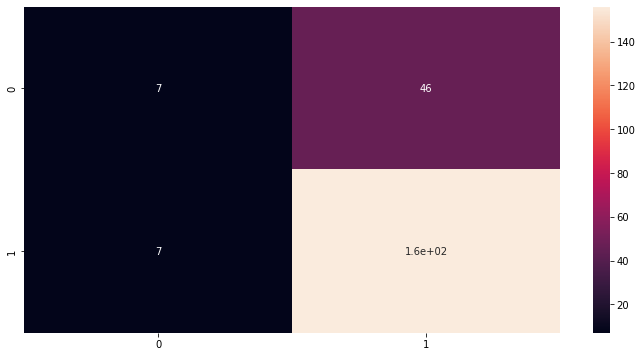

In [71]:
cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)
import seaborn as sns
sns.heatmap(cm, annot=True)

### AUC for classifier



In [72]:
# This function takes as input a list of classifiers, test and train data. It evaluates the models
# using stratifiedKfold (10 by default) and outputs the average Accuracy and AUC scores. Additionally,
# it also plots the ROC curve for all the classifiers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import datetime as dt
from scipy.stats import gaussian_kde
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
def Evaluation_Metrics(clfs, X, y, n_splits=10):
    plt.figure(figsize=(13, 10))

    for i, clf in enumerate(clfs):
        skf_acc = 0.
        skf_auc = 0.
    
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True)
        for train_index, test_index in skf.split(X, y):
            # Split the data into training and testing sets.
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Fit the model and get predictions.
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            # Calculate and sum the accuracy and AUC scores.
            skf_acc += accuracy_score(y_test, y_pred)
            skf_auc += roc_auc_score(y_test, y_pred)

        # Get the mean accuracy and AUC scores.
        skf_acc = round(skf_acc / n_splits, 3)
        skf_auc = round(skf_auc / n_splits, 3)

        # Get the classifier name.
        clf_name = str(type(clf)).split('.')[-1][:-2]

        # Print the AUC and ACC scores for the particular model
        print("{} \n\tAcc: {}\n\tAUC: {}\n".format(clf_name, skf_acc, skf_auc))

        # Get FPR, TPR, and corresponding thresholds.
        fpr, tpr, thresh = roc_curve(y_test, y_pred)

        # Plot the ROC curve.
        plt.plot(fpr, tpr, linewidth=2.5,
                 label="AUC: {}, {}".format(skf_auc, clf_name))
        
    # Plot baseline ,i.e, y = x line segment.
    plt.plot([0, 1], [0, 1], '--', linewidth=1, color='gray')

    # Specify plot details.
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xticks(np.arange(0.0, 1.1, 0.1), fontsize=12)
    plt.yticks(np.arange(0.0, 1.1, 0.1), fontsize=12)
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.ylabel("True Positive Rate", fontsize=15)
    plt.yticks(fontsize=12)
    plt.legend(loc=0, fontsize=15)
    plt.title("ROC Curves", fontsize=17);

KNeighborsClassifier 
	Acc: 0.533
	AUC: 0.516

DecisionTreeClassifier 
	Acc: 0.749
	AUC: 0.525

RandomForestClassifier 
	Acc: 0.763
	AUC: 0.499

QuadraticDiscriminantAnalysis 
	Acc: 0.742
	AUC: 0.496

AdaBoostClassifier 
	Acc: 0.73
	AUC: 0.491



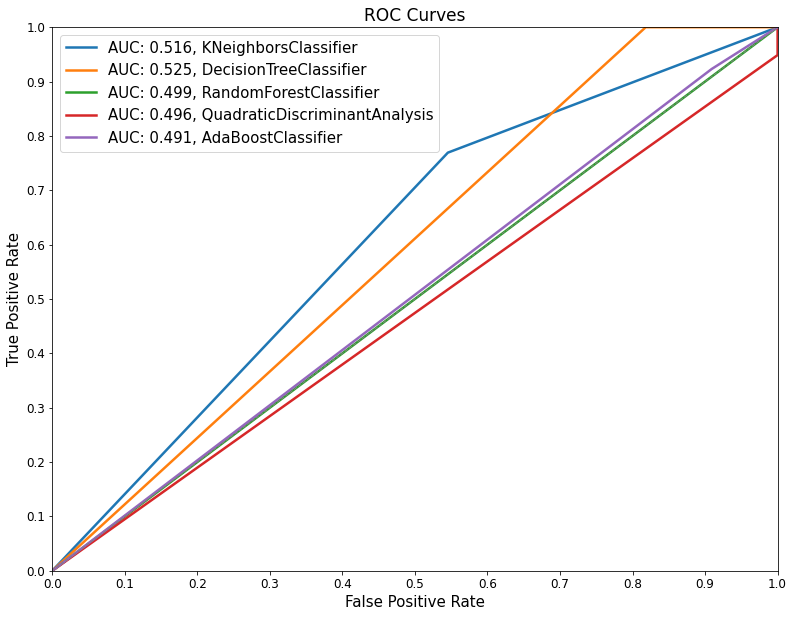

In [73]:
Evaluation_Metrics(classifiers, X_train, y_train)

Better AUC means better the capability of the classifier to predict the model. Random forest has an 0.526.

## 5.3 Regression using muller loop
For regression I would use the relation between the price and rent of the home

In [74]:
data_regression

,price,bathrooms,bedrooms,area,zestimate,rent_zestimate,days_on_zillow
11,1950000.0,4.0,4.0,404,1950000.0,4925.0,7.0
20,925000.0,3.0,3.0,235,961600.0,3694.0,2.0
27,1050000.0,4.0,3.0,270,1050000.0,3584.0,21.0
28,419900.0,1.0,2.0,500,296100.0,1542.0,1.0
40,315000.0,2.0,2.0,130,315000.0,2133.0,24.0
...,...,...,...,...,...,...,...
5826,249900.0,2.0,2.0,593,257700.0,1597.0,0.0
5837,1089000.0,3.0,3.0,331,1114900.0,3965.0,7.0
5846,3450000.0,5.0,4.0,522,3450000.0,11352.0,11.0
5866,599000.0,1.0,3.0,90,604500.0,2296.0,22.0


In [75]:
X_reg = data_regression[['price']] 
y_reg = data_regression[['rent_zestimate']]

In [76]:
# Train the dataset
X_trainr, X_testr, y_trainr, y_testr = train_test_split(X_reg, y_reg, test_size=0.30)
y_trainr = y_trainr.values.ravel()
names = ["Nearest Neighbors", "Linear SVR", "Gaussian Process",
         "Decision Tree", "Random Forest", "MLP", "AdaBoost"
         ]

In [77]:
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

In [78]:

regression = [
    KNeighborsRegressor(2),
    SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=- 1),
    GaussianProcessRegressor(kernel=None, alpha=1e-10, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=0, normalize_y=False, copy_X_train=True, random_state=None),
    DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, ccp_alpha=0.0),
    RandomForestRegressor(max_depth=5, n_estimators=10, max_features=1),
    MLPRegressor(alpha=1, max_iter=1500),
    AdaBoostRegressor(base_estimator=None, n_estimators=50, learning_rate=1.0, loss='linear', random_state=None)
    ]
reg_output = pd.DataFrame(columns=['regressor','mae', 'mse', 'Rsquared', 'accuracy', 'Training time'])

In [79]:
max_score = 0.0
max_class = ''
# iterate over regressor
for name, clf in zip(names, regression):
    start_time = time.process_time()
    time_finish = time.process_time() - start_time
    clf.fit(X_trainr, y_trainr)
  
    score = 100.0 * clf.score(X_testr, y_testr)
    y_predict = clf.predict(X_testr)

    
    mae = np.round(metrics.mean_absolute_error(y_test, y_predict), 2)
    mse = np.round(metrics.mean_squared_error(y_test, y_predict), 2)
    rsquared = np.round(metrics.r2_score(y_test, y_predict), 2)
    reg_output = reg_output.append({'regressor': name, 'mae':mae, 'mse':mse,'Rsquared':rsquared, 'accuracy':score, 'Training time':time_finish}, ignore_index=True)
    print('Regression = %s, Score (accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds,'%(time.process_time() - start_time))
    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name
print(80*'-' )
print('Best --> Regression = %s, Score (accuracy) = %.2f' %(max_class, max_score),'Training time = %.2f seconds,'%(time.process_time() - start_time))

Regression = Nearest Neighbors, Score (accuracy) = 68.76, Training time = 0.01 seconds,
Regression = Linear SVR, Score (accuracy) = -0.37, Training time = 0.03 seconds,
Regression = Gaussian Process, Score (accuracy) = -73.32, Training time = 0.13 seconds,
Regression = Decision Tree, Score (accuracy) = 66.21, Training time = 0.06 seconds,
Regression = Random Forest, Score (accuracy) = 72.70, Training time = 0.11 seconds,
Regression = MLP, Score (accuracy) = 79.04, Training time = 0.24 seconds,
Regression = AdaBoost, Score (accuracy) = 68.55, Training time = 0.09 seconds,
--------------------------------------------------------------------------------
Best --> Regression = MLP, Score (accuracy) = 79.04 Training time = 0.09 seconds,


The accuracy of the model is around 50%. This is predicted as the pricing and rent depends on many factors such as location, investment intrest etc 

In [80]:
# Save the pickle file
import pickle 
filename = '/content/drive/MyDrive/Machine Learning-MidTerm/regression_model.sav'
pickle.dump(clf_best, open(filename, 'wb'))
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
# Load the saved model and evaluating it provides an estimate of accuracy of the model on test data.
result = loaded_model.score(X_testr, y_testr)
print(result)

0.7904238712991003


In [81]:
display(reg_output)

,regressor,mae,mse,Rsquared,accuracy,Training time
0,Nearest Neighbors,2785.68,10152917.38,-54832099.16,68.764383,0.000006
1,Linear SVR,2495.80,6232959.12,-33661874.32,-0.365033,0.000003
2,Gaussian Process,1578.67,4617215.07,-24935846.45,-73.318267,0.000005
3,Decision Tree,2782.73,11120498.18,-60057640.29,66.207378,0.000005
4,Random Forest,2795.65,9976467.63,-53879160.23,72.703168,0.000003
5,MLP,2367.49,10631336.52,-57415861.58,79.042387,0.000003
6,AdaBoost,2690.44,9968461.28,-53835920.90,68.545688,0.000005


## Results from classifier and regression model
1. The regression model accuracy could be improved by adding other additional features such as school rates, crime in the location, walkability score to improve the performace. 
2.To contiuous data the Decision Tree regressor worked well.
3. For categorical data almost all classifiers had an accuracy of 70% apart from nearest neighbors this might be due to clustering

In [82]:
display(reg_output, class_output)


,regressor,mae,mse,Rsquared,accuracy,Training time
0,Nearest Neighbors,2785.68,10152917.38,-54832099.16,68.764383,0.000006
1,Linear SVR,2495.80,6232959.12,-33661874.32,-0.365033,0.000003
2,Gaussian Process,1578.67,4617215.07,-24935846.45,-73.318267,0.000005
3,Decision Tree,2782.73,11120498.18,-60057640.29,66.207378,0.000005
4,Random Forest,2795.65,9976467.63,-53879160.23,72.703168,0.000003
5,MLP,2367.49,10631336.52,-57415861.58,79.042387,0.000003
6,AdaBoost,2690.44,9968461.28,-53835920.90,68.545688,0.000005


,classifier,F1 score,accuracy,Training time
0,Nearest Neighbors,0.52,48.148148,0.000005
1,Decision Tree,0.67,72.222222,0.000007
2,Random Forest,0.65,74.537037,0.000006
3,QDA,0.67,74.537037,0.000029
4,AdaBoost,0.68,74.074074,0.000006


In [83]:
data_regression

,price,bathrooms,bedrooms,area,zestimate,rent_zestimate,days_on_zillow
11,1950000.0,4.0,4.0,404,1950000.0,4925.0,7.0
20,925000.0,3.0,3.0,235,961600.0,3694.0,2.0
27,1050000.0,4.0,3.0,270,1050000.0,3584.0,21.0
28,419900.0,1.0,2.0,500,296100.0,1542.0,1.0
40,315000.0,2.0,2.0,130,315000.0,2133.0,24.0
...,...,...,...,...,...,...,...
5826,249900.0,2.0,2.0,593,257700.0,1597.0,0.0
5837,1089000.0,3.0,3.0,331,1114900.0,3965.0,7.0
5846,3450000.0,5.0,4.0,522,3450000.0,11352.0,11.0
5866,599000.0,1.0,3.0,90,604500.0,2296.0,22.0


Text(600, 1000000, 'y = 441.1x + 616076.38')

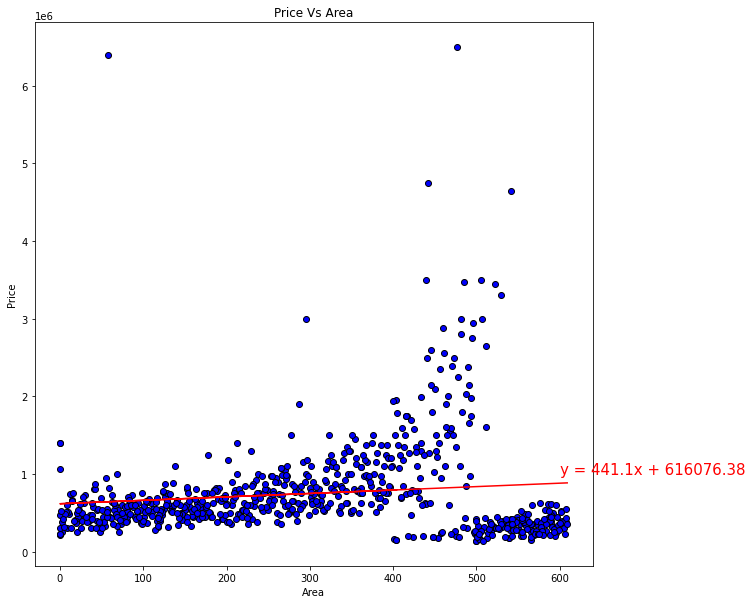

In [84]:
from scipy.stats import linregress
fig = plt.figure(figsize=(10,10))
acres_burned = data_regression["price"].tolist()
days = data_regression['area'].tolist()
plt.scatter(days, acres_burned, marker="o", facecolors="blue", edgecolors="black")
plt.title("Price Vs Area")
plt.xlabel("Area")
plt.ylabel("Price")
x_values = data_regression['area']
y_values = data_regression["price"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(600,1000000),fontsize=15,color="red")

Price and area are co-realated to each other. If area increases the price increases

In [85]:
selected_col_reg=["price", "rent_zestimate"]
df_reg=data_regression[selected_columns]
sc_X = StandardScaler()
df_reg=sc_X.fit_transform(df_reg)
df_reg=pd.DataFrame(df_reg, columns=selected_col_reg)
df_reg

,price,rent_zestimate
0,1.867639,2.043568
1,0.272155,0.443526
2,0.466727,0.586629
3,-0.514068,-0.633800
4,-0.677352,-0.603204
...,...,...
714,-0.778684,-0.695962
715,0.527433,0.691691
716,4.202493,4.471799
717,-0.235286,-0.134555


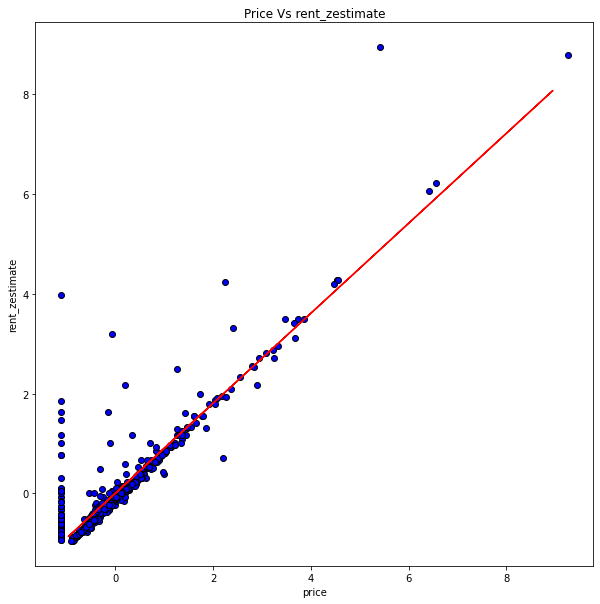

In [86]:
from scipy.stats import linregress
fig = plt.figure(figsize=(10,10))
acres_burned = df_reg["price"].tolist()
days = df_reg['rent_zestimate'].tolist()
plt.scatter(days, acres_burned, marker="o", facecolors="blue", edgecolors="black")
plt.title("Price Vs rent_zestimate")
plt.xlabel("price")
plt.ylabel("rent_zestimate")
x_values = df_reg['price']
y_values = df_reg["rent_zestimate"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_values,regress_values,"r-")

Rent and price are also related to each other, as rent increases the price of the home also increases

 ## Latent variables and Latent Manifolds
1. To predict the ROI of the homes and to convience that buying homes gives good ROI in the Denver area
2. Data taken from zillow https://www.zillow.com/research/data/
3. We are using regionId as the latent variable to find if there is any impact in ROI for homes


In [87]:
path="/content/drive/MyDrive/Machine Learning-MidTerm/Dataset/dataset/zillow_clean.csv"
data_lv = pd.read_csv(path)
data_lv=data_lv[(data_lv.State.str.contains('CO', flags=re.IGNORECASE|re.DOTALL)==True)]
data_lv1= data_lv.copy()
data_lv

,RegionID,RegionName,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,...,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
20,11093,Denver,CO,Denver,Denver,21,98700.0,99200.0,99600.0,100200.0,101100.0,102000.0,102700.0,103400.0,104600.0,106500.0,108800.0,111000.0,113200.0,115400.0,117400.0,119400.0,121100.0,122700.0,124200.0,125400.0,126000.0,126400.0,126800.0,127200.0,127500.0,127900.0,128400.0,129100.0,130000.0,131000.0,132200.0,133600.0,135100.0,137100.0,...,244800,247500,250100,252400,254300,255400,256400,257700,259800,262500,265800,268600,271000,273000,274700,277300,280500,283700,287200,290800,293700,297300,301900,306500,310600,314000,317000,320400,324100,327700,330500,332100,333500,335600,337600,339700,342700,345900,349800,353300
35,4172,Colorado Springs,CO,Colorado Springs,El Paso,36,126200.0,127000.0,127500.0,128000.0,128200.0,128300.0,128400.0,128500.0,128600.0,129000.0,129400.0,129400.0,129300.0,129300.0,129400.0,129300.0,129300.0,129700.0,130200.0,130700.0,131100.0,131600.0,132300.0,133000.0,133200.0,133400.0,133600.0,133900.0,134300.0,134500.0,134600.0,135000.0,135400.0,136200.0,...,197100,199000,200300,201400,201800,201000,200700,201200,201800,202600,203800,204500,204800,205100,205200,206000,207800,209800,211100,211400,210800,210700,211900,213200,214200,214800,215600,216900,218800,220400,221500,222100,222800,223700,225000,226800,229000,231100,233100,235000
50,16846,Aurora,CO,Denver,Arapahoe,51,107600.0,107700.0,108000.0,108300.0,108900.0,109500.0,109700.0,110200.0,110900.0,111500.0,111900.0,112300.0,112900.0,113500.0,114200.0,114800.0,115300.0,115800.0,116500.0,117400.0,118200.0,119000.0,119700.0,120400.0,121000.0,121500.0,122000.0,122800.0,123700.0,124600.0,125500.0,126300.0,127300.0,128300.0,...,170400,173000,175000,176600,177700,178700,180200,181400,181900,182700,184400,186100,188200,191000,193700,196000,198300,201000,203900,206700,209300,212000,215400,219000,222300,225200,228000,231200,235000,238500,240900,242600,244400,247300,250500,253200,256200,259500,262200,264300
134,4764,Fort Collins,CO,Fort Collins,Larimer,135,142800.0,142600.0,142400.0,142300.0,142400.0,142600.0,142700.0,142900.0,143100.0,143300.0,143300.0,143100.0,142600.0,142100.0,142100.0,142500.0,142900.0,143400.0,144300.0,145200.0,145800.0,146600.0,147700.0,148500.0,149100.0,149500.0,149800.0,149800.0,149900.0,150000.0,150200.0,150500.0,151100.0,152300.0,...,240300,242000,243600,245400,247800,249700,251100,252100,253400,254800,256600,258300,260400,262200,263900,265800,268100,270100,271600,273500,275800,278300,281700,285600,289400,293300,297300,301300,304900,308100,311200,313900,315800,317700,319900,322000,324300,327100,330500,333500
159,47250,Pueblo,CO,Pueblo,Pueblo,160,81100.0,81300.0,81700.0,82100.0,82400.0,82600.0,83000.0,83100.0,83200.0,83200.0,83200.0,82900.0,83000.0,83300.0,83500.0,83200.0,83300.0,83700.0,84300.0,84900.0,85600.0,86500.0,87100.0,87500.0,87800.0,88100.0,88600.0,89300.0,89800.0,89800.0,89800.0,90000.0,90500.0,90800.0,...,107900,108000,108300,108800,109200,109500,109800,110000,109900,110100,110700,111300,111700,112200,113000,114100,114900,115500,115900,116300,117000,117700,118400,119300,120300,121000,121700,122200,122700,123800,125000,125500,125600,126000,126500,127000,128000,129000,129900,130600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [88]:
# Transforming data and dropping null values
data_lv = pd.melt(data_lv, 
             id_vars=['RegionID', 'RegionName', 'State', 'Metro', 
                      'CountyName', 'SizeRank'], var_name='Date', 
             value_name='Property Value')

data_lv['Date'] = pd.to_datetime(data_lv['Date'], infer_datetime_format=True)
data_lv.set_index('Date', inplace=True)
# Dropping resulting nulls
data_lv = data_lv.dropna(subset=['Property Value'])
print(data_lv.shape)
data_lv.head()

(36804, 7)


,RegionID,RegionName,State,Metro,CountyName,SizeRank,Property Value
Date,,,,,,,
1996-04-01,11093,Denver,CO,Denver,Denver,21,98700.0
1996-04-01,4172,Colorado Springs,CO,Colorado Springs,El Paso,36,126200.0
1996-04-01,16846,Aurora,CO,Denver,Arapahoe,51,107600.0
1996-04-01,4764,Fort Collins,CO,Fort Collins,Larimer,135,142800.0
1996-04-01,47250,Pueblo,CO,Pueblo,Pueblo,160,81100.0


In [89]:
# Full dataset observations
ts = data_lv.groupby('Date').aggregate({'Property Value':'mean'})
ts.head()

,Property Value
Date,
1996-04-01,138545.6
1996-05-01,139267.2
1996-06-01,139975.2
1996-07-01,140524.8
1996-08-01,141032.8


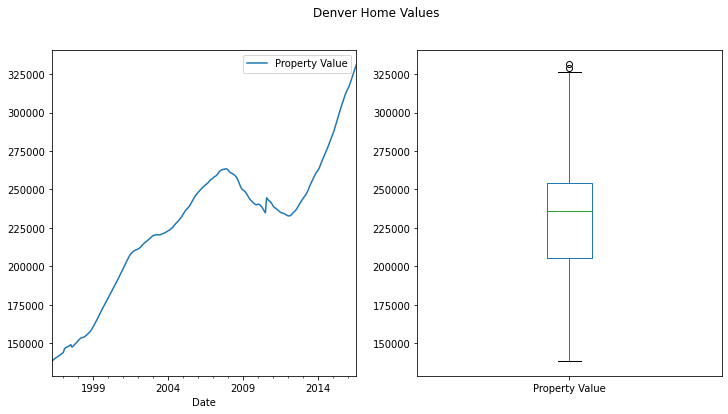

In [90]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6))
ts.plot(ax = axes[0])
ts.boxplot(ax = axes[1],grid=False);
fig.suptitle('Denver Home Values')
plt.show()

1. We can see that the property values in Denver region is increasing from 1999 to 2014
2. The median value homes in 2019 is around 250000
3. Median salary in Denver area is around 68, 592 https://www.census.gov/quickfacts/fact/table/denvercountycolorado/INC110219  so most of the expensive homes in zillow are not sold

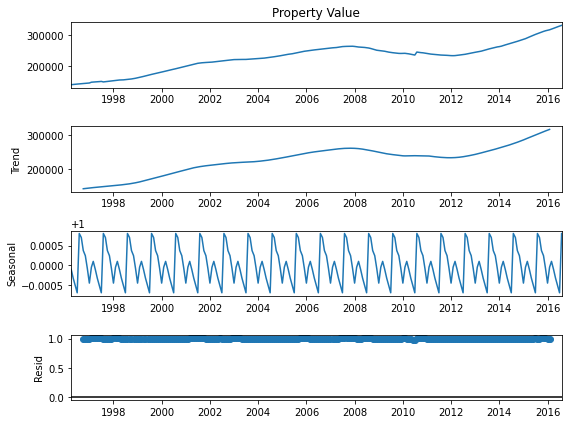

In [91]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams.update({'figure.figsize': (8,6), 'figure.dpi':72})
CO = seasonal_decompose(ts['Property Value'], model='multiplicative')  # model='mul' also works
CO.plot();

The property value in Denver has always increased between 1998 to 2016. There is seasonal drop due to the harsh winters in the Denver area.

In [92]:
# Calculating 2 year investment period (percent)
ts_2y = (ts - ts.shift(periods=24))/ts.shift(periods=24)*100
ts_2y.dropna(inplace=True)

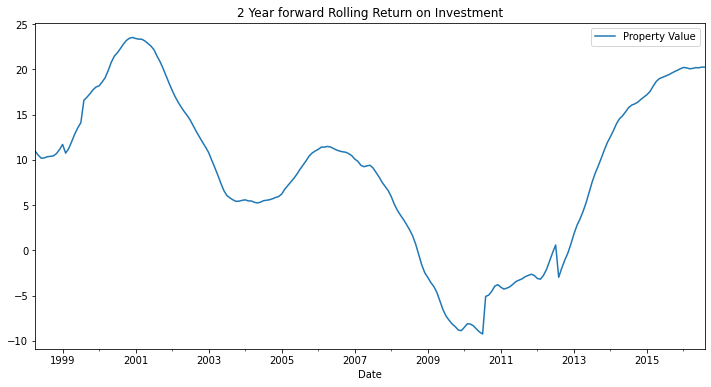

In [93]:
ts_2y.plot(figsize=(12,6),title='2 Year forward Rolling Return on Investment');

1. Two year return on inverstement is also high. This graph shows the profit of buying a house in the last two years
2. We can also notice that the homes profit dropped between 2009 to 2013 this was due to the great depression

### Analysis of homes based on regionID
In this technique we are selecting the top four region Ids and calculating the 2 year investment trend in the following regionIds

In [94]:
data_lv1.head(2)

,RegionID,RegionName,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,...,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08
20,11093,Denver,CO,Denver,Denver,21,98700.0,99200.0,99600.0,100200.0,101100.0,102000.0,102700.0,103400.0,104600.0,106500.0,108800.0,111000.0,113200.0,115400.0,117400.0,119400.0,121100.0,122700.0,124200.0,125400.0,126000.0,126400.0,126800.0,127200.0,127500.0,127900.0,128400.0,129100.0,130000.0,131000.0,132200.0,133600.0,135100.0,137100.0,...,244800,247500,250100,252400,254300,255400,256400,257700,259800,262500,265800,268600,271000,273000,274700,277300,280500,283700,287200,290800,293700,297300,301900,306500,310600,314000,317000,320400,324100,327700,330500,332100,333500,335600,337600,339700,342700,345900,349800,353300
35,4172,Colorado Springs,CO,Colorado Springs,El Paso,36,126200.0,127000.0,127500.0,128000.0,128200.0,128300.0,128400.0,128500.0,128600.0,129000.0,129400.0,129400.0,129300.0,129300.0,129400.0,129300.0,129300.0,129700.0,130200.0,130700.0,131100.0,131600.0,132300.0,133000.0,133200.0,133400.0,133600.0,133900.0,134300.0,134500.0,134600.0,135000.0,135400.0,136200.0,...,197100,199000,200300,201400,201800,201000,200700,201200,201800,202600,203800,204500,204800,205100,205200,206000,207800,209800,211100,211400,210800,210700,211900,213200,214200,214800,215600,216900,218800,220400,221500,222100,222800,223700,225000,226800,229000,231100,233100,235000


In [95]:
def transform(df):
    '''Transforms data from wide to long format/sets datetime as index'''
    transformed = pd.melt(df, 
                          id_vars=['RegionID', 'RegionName', 'State', 'Metro', 
                                   'CountyName', 'SizeRank'], 
                          var_name='Date', value_name='Property Value')
    
    transformed['Date'] = pd.to_datetime(transformed['Date'], infer_datetime_format=True)
    transformed = transformed.dropna(subset=['Property Value'])
    return transformed

In [96]:
denver_ts_dict = {}

for z in data_lv1.RegionID.unique(): # iterate through zip codes
    startdf = data_lv1[data_lv1.RegionID == z] # each zip code
    start_ts = transform(startdf) # time series (melt) per zip code
    start_ts2 = start_ts.groupby('Date').aggregate({'Property Value':'mean'})
    denver_ts_dict[z] = start_ts2 # adding to dictionary

In [97]:
# Calculating the 2 year rolling ROI per zipcode in dictionary of dataframes
R2ROI = {}
for i, key in enumerate(denver_ts_dict):
    denver = (denver_ts_dict[key] - denver_ts_dict[key].shift(periods=24))/denver_ts_dict[key].shift(periods=24)*100
    denver.dropna(inplace=True)
    R2ROI[list(denver_ts_dict.keys())[i-1]] = denver


In [98]:
# filter only 15 highest current return zipcodes
M12_R2ROI = {}
for i, key in enumerate(R2ROI):
    M12_R2ROI[list(R2ROI.keys())[i-1]] = R2ROI[key].iloc[-13:-1].values.mean() # 12 month mean of rolling means
    # from_dict keys-columns | orient new key-row
    R12R2 = pd.DataFrame.from_dict(M12_R2ROI, orient='index', columns=['12 Month Mean (R2M)'])
    R12R2 = R12R2.nlargest(5, ['12 Month Mean (R2M)']) # 5 Largest Values

In [99]:
R12R2

,12 Month Mean (R2M)
10710,50.616751
13759,46.917925
119632,45.371111
24889,42.382097
396537,41.196034


In [100]:
top5 = [10710	,13759,119632,24889,396537]
df_lv = data_lv1[(data_lv1.RegionID.isin(top5))]
df_lv = df_lv.drop(df_lv.loc[:, '1996-04':'2008-06'].columns, axis = 1)
df_lv = transform(df_lv)


In [101]:
df_lv['Date'] = pd.to_datetime(df_lv['Date'], infer_datetime_format=True)
df_lv.set_index('Date', inplace=True)
# Dropping resulting nulls from melt
df_lv = df_lv.dropna(subset=['Property Value'])
print(df_lv.shape)
df_lv.head()

(490, 7)


,RegionID,RegionName,State,Metro,CountyName,SizeRank,Property Value
Date,,,,,,,
2008-07-01,24889,Glenwood Springs,CO,Glenwood Springs,Garfield,2817,447400.0
2008-07-01,396537,Stratmoor,CO,Colorado Springs,El Paso,5281,132900.0
2008-07-01,13759,Sedalia,CO,Denver,Douglas,5867,413700.0
2008-07-01,10710,Carbondale,CO,Glenwood Springs,Garfield,6389,514300.0
2008-07-01,119632,Genesee,CO,Denver,Jefferson,7640,555200.0


In [102]:
df_lv = df_lv[['RegionID','Property Value']]
df_lv.rename({'Property Value': 'Property_Value'}, axis='columns', inplace=True)
df_lv['RegionID'] = df_lv['RegionID'].astype('category')

In [103]:
differencing = df_lv.copy()

In [104]:
# Time Series Per Zip Code
# List containing the 5 different time series.
df_ts = []
for z in top5:
    #Create separate dataframes for each zipcode with a monthly frequency.
    df2 = df_lv[df_lv['RegionID']==z].asfreq('MS')
    df_ts.append(df2)
print('\nZipCode Time Series:')
df_ts[0].head()


ZipCode Time Series:


,RegionID,Property_Value
Date,,
2008-07-01,10710,514300.0
2008-08-01,10710,507900.0
2008-09-01,10710,503600.0
2008-10-01,10710,501000.0
2008-11-01,10710,498700.0


In [105]:
# Separating out dataframes / instantiating
zip10710 = df_ts[0].Property_Value
# Test/Train Split
train10710 = zip10710.iloc[:95] # up to not inc 95 
test10710 = zip10710.iloc[94:] # after 93

In [106]:
# Separating out dataframes / instantiating
zip13759 = df_ts[1].Property_Value
# Test/Train Split
train13759 = zip13759.iloc[:95] # up to not inc 95 
test13759 = zip13759.iloc[94:] # after 93

In [107]:
# Separating out dataframes / instantiating
zip119632 = df_ts[2].Property_Value
# Test/Train Split
train119632 = zip119632.iloc[:95] # up to not inc 94 
test119632 = zip119632.iloc[94:] # after 93

In [108]:
# Separating out dataframes / instantiating
zip24889 = df_ts[3].Property_Value
train24889 = zip24889.iloc[:95] # up to not inc 95 
test24889 = zip24889.iloc[94:] # after 93

In [109]:
# Grid search function
import pmdarima as pm
def parameters(ts):
    '''Using a grid search function to find the best parameters for modeling'''
    stepwise_fit = pm.auto_arima(ts, start_p=1, start_q=1, test='adf', max_p=10, 
                                 max_q=10, m=12, seasonal=True, d=2, D=1, 
                                 stepwise=True, suppress_warnings=True, trend='ct', 
                                 trace=False, error_action='ignore')
   
    return stepwise_fit.order, stepwise_fit.seasonal_order

In [110]:
# # Saving parameter values for modeling
params10710 = parameters(train10710)
params13759 = parameters(train13759)
params119632 = parameters(train119632)
params24889 = parameters(train24889)

In [111]:
def plot_proj_forecast(ts, model_output, plot=True):
    '''Calculate predicted, forecasted values and return dataframe with values.'''
    # Get forecast and confidence interval for steps ahead in future
    forecast = model_output.predict(len(ts),len(ts)+23,typ='levels').rename('SARIMA Forecast')
    future = model_output.get_forecast(steps=24, dynamic=True)
    future_conf = future.conf_int()

    # plot results
    ax = ts['2014':].plot(label='Observed', figsize=(12, 8))
    future.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(future_conf.index, future_conf.iloc[:, 0], future_conf.iloc[:, 1], 
                    color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.legend()

    # show prediction for end of step-period (in this case in 2 years future time)
    forecast = future.predicted_mean[-1]
    maximum = future_conf.iloc[-1,1]
    minimum = future_conf.iloc[-1,0]
    predictions = {}
    predictions['forecast'] = forecast
    predictions['maximum'] = maximum
    predictions['minimum'] = minimum
    
    predictions = pd.DataFrame.from_dict(predictions, orient='index', columns=['Zip Code'])
    return predictions

For time series data I am using SARIMAX model to forecast the housing data

In [112]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
def sarima_model(ts, ordervals, s_ordervals):
    '''Function to process a SARIMAX model'''
    model = SARIMAX(ts, order=ordervals, seasonal_order=s_ordervals, trend='ct', 
                    enforce_stationarity=True, enforce_invertibility=False)
    output = model.fit()
    return output

### Analysis of homes in RegionId 10710

In [113]:
print(f'Gridsearch best modeling parameters for ZipCode 10710 are:{params10710}')

Gridsearch best modeling parameters for ZipCode 10710 are:((0, 2, 0), (0, 1, 0, 12))


In [114]:
# Fitting full data
output10710 = sarima_model(zip10710,(0, 2, 0), (0, 1, 0, 12))
output10710.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     Property_Value   No. Observations:                   98
Model:             SARIMAX(0, 2, 0)x(0, 1, 0, 12)   Log Likelihood                -787.099
Date:                            Tue, 12 Oct 2021   AIC                           1580.197
Time:                                    18:32:43   BIC                           1587.490
Sample:                                07-01-2008   HQIC                          1583.129
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -109.1934    904.089     -0.121      0.904   -1881.175    1662.789
drift          2.6939     12.928      0.208      0.835     -22.644      28.032
sigma2      8.061e+06   1.05e+06      7.648      0.000       6e+06    1.01e+07
===================================================================================
Ljung-Box (L1) (Q):                  11.73   Jarque-Bera (JB):                 2.21
Prob(Q):                              0.00   Prob(JB):                         0.33
Heteroskedasticity (H):               2.75   Skew:                            -0.02
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

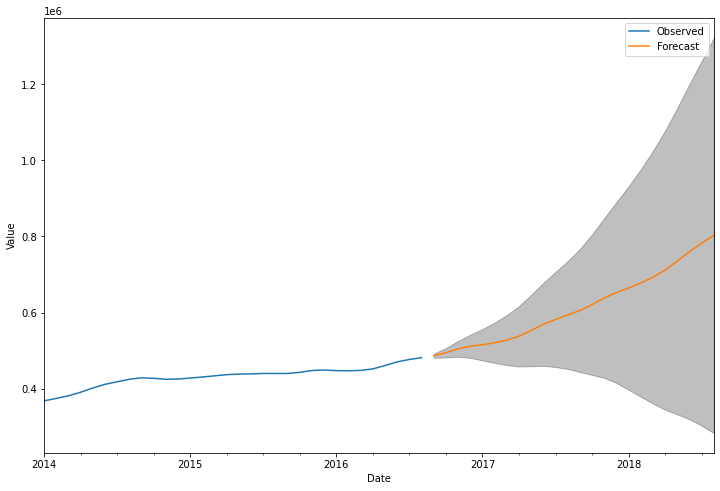

In [115]:
predictions = plot_proj_forecast(zip10710, output10710)

Base on the latent variable RegionID of the real-estate we can see that the prtoperty value is increased over the period of time. This might be due to the schools, hospitals in the area and low crime rate in the area

In [116]:
predictions = predictions.T
zip_code_10710 = predictions
zip_code_10710.rename({'Zip Code': '10710'}, inplace=True)

# Analysis of homes with regionID 13759

In [117]:
print(f'Gridsearch best modeling parameters for ZipCode 13759 are:{params13759}')


Gridsearch best modeling parameters for ZipCode 13759 are:((0, 2, 0), (0, 1, 0, 12))


In [118]:
output13759 = sarima_model(zip13759,(0, 2, 0), (0, 1, 0, 12))
output13759.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     Property_Value   No. Observations:                   98
Model:             SARIMAX(0, 2, 0)x(0, 1, 0, 12)   Log Likelihood                -819.776
Date:                            Tue, 12 Oct 2021   AIC                           1645.553
Time:                                    18:32:43   BIC                           1652.845
Sample:                                07-01-2008   HQIC                          1648.484
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    138.3714    969.126      0.143      0.886   -1761.081    2037.824
drift         -3.9642     22.649     -0.175      0.861     -48.355      40.427
sigma2      1.755e+07   1.78e+06      9.886      0.000    1.41e+07     2.1e+07
===================================================================================
Ljung-Box (L1) (Q):                   5.40   Jarque-Bera (JB):                25.45
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

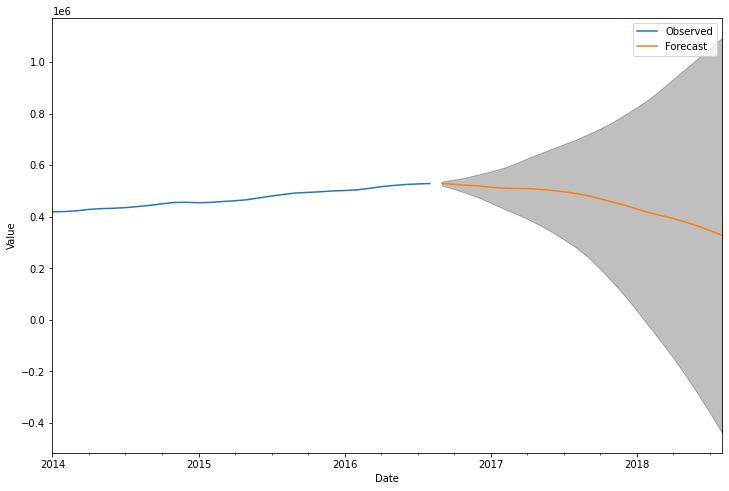

In [119]:
predictions = plot_proj_forecast(zip13759, output13759)

In [120]:
predictions = predictions.T
zip_code_13759 = predictions
zip_code_13759.rename({'Zip Code': '13759'}, inplace=True)

# Analysis of homes with regionId 119632

In [121]:
print(f'Gridsearch best modeling parameters for ZipCode 119632 are:{params119632}')

Gridsearch best modeling parameters for ZipCode 119632 are:((0, 2, 0), (0, 1, 0, 12))


In [122]:
output119632 = sarima_model(zip119632,(0, 2, 0), (0, 1, 0, 12))
output119632.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     Property_Value   No. Observations:                   98
Model:             SARIMAX(0, 2, 0)x(0, 1, 0, 12)   Log Likelihood                -825.371
Date:                            Tue, 12 Oct 2021   AIC                           1656.742
Time:                                    18:32:44   BIC                           1664.034
Sample:                                07-01-2008   HQIC                          1659.673
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     76.7673    966.189      0.079      0.937   -1816.928    1970.462
drift         -0.7084     22.484     -0.032      0.975     -44.777      43.360
sigma2      2.005e+07   1.85e+06     10.848      0.000    1.64e+07    2.37e+07
===================================================================================
Ljung-Box (L1) (Q):                   5.55   Jarque-Bera (JB):                47.78
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

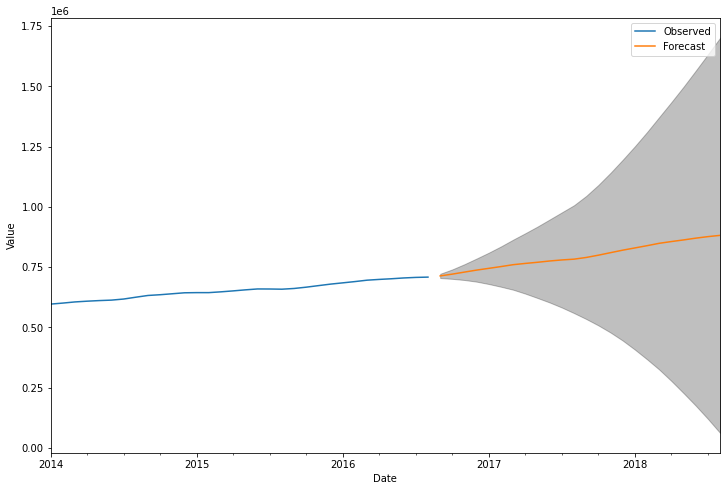

In [123]:
predictions = plot_proj_forecast(zip119632, output119632)

In [124]:
predictions = predictions.T
zip_code_119632 = predictions
zip_code_119632.rename({'Zip Code': '119632'}, inplace=True)

# Analysis of homes with regionID: 24889

In [125]:
print(f'Gridsearch best modeling parameters for ZipCode 24889 are:{params24889}')

Gridsearch best modeling parameters for ZipCode 24889 are:((0, 2, 0), (0, 1, 0, 12))


In [126]:

output24889 = sarima_model(zip24889,(0, 2, 0), (0, 1, 0, 12))
output24889.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                     Property_Value   No. Observations:                   98
Model:             SARIMAX(0, 2, 0)x(0, 1, 0, 12)   Log Likelihood                -775.311
Date:                            Tue, 12 Oct 2021   AIC                           1556.622
Time:                                    18:32:44   BIC                           1563.915
Sample:                                07-01-2008   HQIC                          1559.554
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     80.9359    773.587      0.105      0.917   -1435.266    1597.138
drift         -2.3848     11.620     -0.205      0.837     -25.159      20.389
sigma2      6.088e+06   9.21e+05      6.609      0.000    4.28e+06    7.89e+06
===================================================================================
Ljung-Box (L1) (Q):                  17.09   Jarque-Bera (JB):                 0.07
Prob(Q):                              0.00   Prob(JB):                         0.96
Heteroskedasticity (H):               1.89   Skew:                             0.00
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

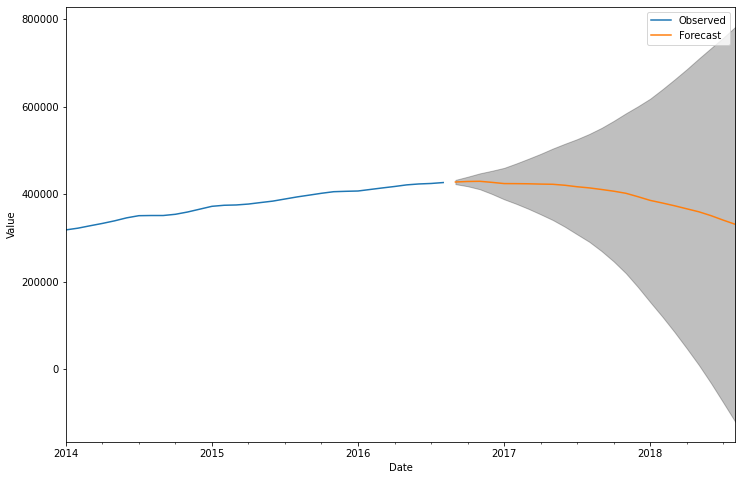

In [127]:
predictions = plot_proj_forecast(zip24889, output24889)

In [128]:
predictions = predictions.T
# Saving for final numbers
zip_code_24889 = predictions
zip_code_24889.rename({'Zip Code': '24889'}, inplace=True)

In [129]:
frames = [zip_code_10710,zip_code_13759, zip_code_119632, zip_code_24889]
df = pd.concat(frames)

In [130]:
df1 = differencing.tail()
df1 = df1.reset_index()
df1 = df1[['Property_Value']]

df = df.reset_index()
df = pd.concat([df, df1.reindex(df.index)], axis=1)
df = df.rename(columns={'index':'ZipCode', 'Property_Value':'Investment'})

In [131]:
df

,ZipCode,forecast,maximum,minimum,Investment
0,10710,802882.443909,1.322575e+06,283189.779659,426300.0
1,13759,327502.352025,1.094327e+06,-439322.548465,160600.0
2,119632,881742.876038,1.701394e+06,62091.740864,528500.0
3,24889,330784.573421,7.824350e+05,-120865.810727,481400.0


In [132]:
df['Min_ROI'] = df['minimum'] - df['Investment']
df['Max_ROI'] = df['maximum'] - df['Investment']
df['ROI'] = df['forecast'] - df['Investment']

In [133]:
pd.options.display.float_format = '{:.0f}'.format

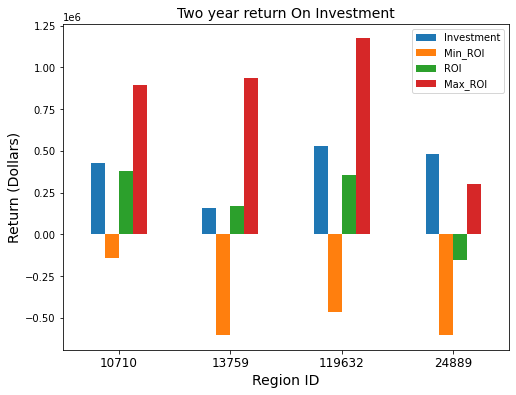

In [134]:

df['ZipCode'] = df['ZipCode'].astype('category')
df.set_index('ZipCode', inplace=True)
df = df[['Investment','Min_ROI','ROI','Max_ROI']]
ax = df.plot.bar()
for item in ax.get_xticklabels():
    item.set_rotation(0)
    item.set_size(12)
plt.title('Two year return On Investment', fontdict={'fontsize': 14})
plt.ylabel('Return (Dollars)', fontdict={'fontsize': 14})
plt.xlabel('Region ID', fontdict={'fontsize': 14})
plt.show()

Looking at the above graph green color indicates the ROI the people are receiving currently. The max and min ROI predictions can change due to various latent factors such as amenities change, development in the region etc

Summary,
1. It is worth buying a home in Denver region as the two years ROI has been giving a profit of 25 %. Apart from 2008 to 2013 where there was a loss this was due to the great depression years.
2. If the area of the land is more then house price and the rent is high. They are directly co-related.
3. The real-estate price in the Denver region has always increased over the years but there are few seasonal drops. This might be due to the harsh winters in the Denver region.
4. In the investment point of view it might be a good idea to invest in realestate in the Denver region as there are good returns

